In [5]:
import pandas as pd
import os
import numpy as np
import seaborn as sns

os.chdir("/net/trapnell/vol1/home/mdcolon/proj/morphseq")
from src.vae.auxiliary_scripts.assess_vae_results import assess_vae_results

from src.functions.embryo_df_performance_metrics import (split_train_test, 
                                                        logistic_regression_multiclass, 
                                                        f1_score_over_time_multiclass,
                                                        plot_f1_score_over_time,
                                                        create_f1_score_dataframe,
                                                        compute_average_f1_score,
                                                        plot_average_f1_score_difference,
                                                        compute_metrics_for_dataframes,
                                                        compute_differences,
                                                        compute_graph_metrics,
                                                        compute_histogram,
                                                        compute_kl_divergence,
                                                        plot_differences_together,
                                                        random_subsample,
                                                        compute_jaccard_similarities,
                                                        plot_jaccard_results,
                                                        produce_performance_metrics,)


def find_embryo_stats_csv(model_path):
    """
    Recursively search for the 'embryo_stats_df.csv' file starting from model_path.

    Parameters:
        model_path (str): The base path to start searching.

    Returns:
        str: The full path to the 'embryo_stats_df.csv' file if found, otherwise None.
    """
    target_file = 'embryo_stats_df.csv'
    
    for root, dirs, files in os.walk(model_path):
        if target_file in files and 'figures' in root:
            return os.path.join(root, target_file)
    
    print(f"File '{target_file}' not found under {model_path}")
    return None


In [2]:

# set key path parameters
root = "/net/trapnell/vol1/home/nlammers/projects/data/morphseq/" # path to top of the data directory
train_folder = "20241107_ds" # name of 'head' training folder that contains all runs
sweep_df_path = os.path.join(root, "metadata", "parameter_sweeps", "sweep01", "")

# load dataframes for each component of the sweep--I've broken it up into 6 chunks, 5 of which are currently running on the cluster (other is on workstation)
df_list = []
for block_num in range(0, 5):
    # load df
    temp_df = pd.read_csv(sweep_df_path + f"sweep01_{block_num:02}.csv")
    # keep only runs that have finished
    temp_df = temp_df.loc[temp_df["completed"]==1, :]
    # add to list
    df_list.append(temp_df)

# combine
sweep_df = pd.concat(df_list, axis=0, ignore_index=True)


In [ ]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from sklearn.decomposition import PCA
import plotly.graph_objs as go

def generate_distinct_color_mapping(perturbations):
    # Ensure 'wt' is the first perturbation if it exists
    if 'wt' in perturbations:
        perturbations = ['wt'] + [p for p in perturbations if p != 'wt']
    
    n = len(perturbations)

    colors = [mcolors.rgb2hex(clr) for clr in sns.color_palette(n_colors=n) ]
    # Create a dictionary mapping each perturbation to a color
    color_mapping = dict(zip(perturbations, colors))
    
    return color_mapping

def plot_pca_highlighted_embryos(
    test_df,
    z_mu_biological_columns,
    perturbations=None,
    # color_mapping=None,
    highlight_embryos=None,
    highlight_colors=None,
    marker_size=5,
    highlight_marker_size=10,
    opacity=0.7,
    title="3D PCA Plot",
    show_legend=True,
    plot=True
):
    """
    Plots a 3D PCA of the provided test_df, highlighting specified embryos and connecting their points with lines.
    """
    # Validate input columns
    required_columns = set(["phenotype", "embryo_id", "snip_id", "predicted_stage_hpf"] + 
    ical_columns)
    missing_columns = required_columns - set(test_df.columns)
    if missing_columns:
        raise ValueError(f"The following required columns are missing from test_df: {missing_columns}")
    
    # Generate color mapping
    color_mapping = generate_distinct_color_mapping(perturbations)
    print(color_mapping)
    # Filter the DataFrame based on specified perturbations
    combined_df = test_df[test_df["phenotype"].isin(perturbations)].copy()
    
    if combined_df.empty:
        raise ValueError("No data available for the specified perturbations.")
    
    # Subset the z_mu_biological_columns for PCA
    z_mu_data = combined_df[z_mu_biological_columns]
    
    # Perform PCA
    pca = PCA(n_components=3)
    pca_embedding = pca.fit_transform(z_mu_data)
    
    # Calculate explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    explained_variance_percentage = 100 * explained_variance_ratio.sum()
    
    # Add PCA results to the DataFrame
    for i in range(3):
        combined_df[f"PCA{i+1}"] = pca_embedding[:, i]
    
    # Initialize Plotly figure
    fig = go.Figure()
    
    # Loop over perturbations and add a trace for each
    for pert in perturbations:
        pert_df = combined_df[combined_df['phenotype'] == pert]
        if pert_df.empty:
            continue
        fig.add_trace(
            go.Scatter3d(
                x=pert_df["PCA1"],
                y=pert_df["PCA2"],
                z=pert_df["PCA3"],
                mode='markers',
                marker=dict(
                    color=color_mapping[pert],
                    size=marker_size,
                    opacity=opacity
                ),
                customdata=pert_df[['embryo_id', 'phenotype', "snip_id", "predicted_stage_hpf"]],
                hovertemplate=(
                    'Embryo ID: %{customdata[0]}<br>'
                    'Perturbation: %{customdata[1]}<br>'
                    'Snip ID: %{customdata[2]}<br>'
                    'Predicted hpf: %{customdata[3]:.2f}<extra></extra>'
                ),
                name=pert,
                showlegend=show_legend
            )
        )
    
    # Update axis labels with explained variance
    axis_titles = {}
    for i in range(3):
        axis_titles[f"PCA{i+1}"] = f"PCA {i+1} ({explained_variance_ratio[i]*100:.2f}% variance)"
    
    fig.update_layout(
        scene=dict(
            xaxis_title=axis_titles.get("PCA1", "PCA 1"),
            yaxis_title=axis_titles.get("PCA2", "PCA 2"),
            zaxis_title=axis_titles.get("PCA3", "PCA 3"),
        ),
        title=f"{title} ({explained_variance_percentage:.2f}% variance explained)",
        margin=dict(l=0, r=0, b=0, t=50),
        legend=dict(
            itemsizing='constant'
        )
    )
    
    # Show the plot
    if plot:
        fig.show()
    
    return fig


In [6]:
# an example
metric_loss_type = "NT-Xet"
margin = 5.0
metric_weight = 50
self_target_prob = 0.25
time_only_flag = 0
beta = .1


#~~~
holdout_flag = 0 

# boolean filter. NOTE THAT SOME COMBOS WILL NOT BE PRESENT (yet)
df_filter = (sweep_df["metric_loss_type"] == metric_loss_type) & (sweep_df["margin"] == margin) & (sweep_df["metric_weight"] == metric_weight) & \
            (sweep_df["self_target_prob"] == self_target_prob) & (sweep_df["time_only_flag"] == time_only_flag) & (sweep_df["holdout_flag"] == holdout_flag) & \
            (sweep_df["beta"] == beta)

# now, get training folder path
if np.any(df_filter):
    model_path = sweep_df.loc[df_filter, "model_path"].values[0]
    model_name = os.path.basename(model_path)
    # a couple of parameters for the model assessment script
    overwrite_flag = False # will skip if it detects the exprected output data already
    n_image_figures = 100  # make qualitative side-by-side reconstruction figures
    #had to change skip figures to true because i didnt have write access. 
    # assess_vae_results(root, train_fold
    
df_all = pd.read_csv(find_embryo_stats_csv(model_path))

#~~~
holdout_flag = 1 

# boolean filter. NOTE THAT SOME COMBOS WILL NOT BE PRESENT (yet)
df_filter = (sweep_df["metric_loss_type"] == metric_loss_type) & (sweep_df["margin"] == margin) & (sweep_df["metric_weight"] == metric_weight) & \
            (sweep_df["self_target_prob"] == self_target_prob) & (sweep_df["time_only_flag"] == time_only_flag) & (sweep_df["holdout_flag"] == holdout_flag) & \
            (sweep_df["beta"] == beta)

# now, get training folder path
if np.any(df_filter):
    model_path = sweep_df.loc[df_filter, "model_path"].values[0]
    model_name = os.path.basename(model_path)
    # a couple of parameters for the model assessment script
    overwrite_flag = False # will skip if it detects the exprected output data already
    n_image_figures = 100  # make qualitative side-by-side reconstruction figures
    #had to change skip figures to true because i didnt have write access. 
    # assess_vae_results(root, train_fold
    
df_hld = pd.read_csv(find_embryo_stats_csv(model_path))
#~~~



# Split the data
df_all_train, df_all_test, df_all = split_train_test(df_all)
df_hld_train, df_hld_test, df_hld = split_train_test(df_hld)

# Define the comparisons (Multiclass) and obtain coloumns for data
pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]

# --- Example usage with logistic_regression_multiclass (all suffix) ---
y_test_all, y_pred_proba_all, log_reg_all, train_df_all, test_df_all = logistic_regression_multiclass(
    df_all_train, df_all_test, z_mu_biological_columns, pert_comparisons)

# --- Example usage with logistic_regression_multiclass (hld suffix) ---
y_test_hld, y_pred_proba_hld, log_reg_hld, train_df_hld, test_df_hld = logistic_regression_multiclass(
    df_hld_train, df_hld_test, z_mu_biological_columns, pert_comparisons)


##all
results_dict_all = f1_score_over_time_multiclass(y_test_all, y_pred_proba_all, test_df_all, pert_comparisons, num_bins=20, max_hpf=40)
dataset_label = 'all_perts_F1'
plot_f1_score_over_time(results_dict_all, pert_comparisons, dataset_label=dataset_label, title="F1 Score Over Time for Perturbations")

#hld
results_dict_hld = f1_score_over_time_multiclass(y_test_hld, y_pred_proba_hld, test_df_hld, pert_comparisons, num_bins=20, max_hpf=40)
dataset_label = 'hld_gdf3_lmx1b_perts_F1'
plot_f1_score_over_time(results_dict_hld, pert_comparisons, dataset_label=dataset_label, title="F1 Score Over Time for Perturbations")



# Call the function
fig = plot_pca_highlighted_embryos(
    test_df=test_df_all,
    z_mu_biological_columns=z_mu_biological_columns,
    perturbations= pert_comparisons,
    marker_size=3,
    highlight_marker_size=5,
    opacity=0.3,
    title="Embryo PCA with Highlights",
    show_legend=True,
    plot=True
)

# Call the function
fig = plot_pca_highlighted_embryos(
    test_df=test_df_hld,
    z_mu_biological_columns=z_mu_biological_columns,
    perturbations= pert_comparisons,
    marker_size=3,
    highlight_marker_size=5,
    opacity=0.3,
    title="Embryo PCA with Highlights",
    show_legend=True,
    plot=True
)

NameError: name 'model_path' is not defined

In [ ]:
# an example
metric_loss_type = "NT-Xent"
margin = 1
metric_weight = 10
self_target_prob = 0.25
time_only_flag = 1
beta = 1


File 'embryo_stats_df.csv' not found under /net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block03_iter071


ValueError: Invalid file path or buffer object type: <class 'NoneType'>

/tmp/6509408.1.trapnell-login.q/ipykernel_1521002/3616453756.py:34: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(embryo_df_path)
/tmp/6509408.1.trapnell-login.q/ipykernel_1521002/3616453756.py:59: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(embryo_df_path)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:113: SettingWithCopyWarning: 
A value is trying

/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:113: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['class_num'] = test_df['class_num'].astype(int)


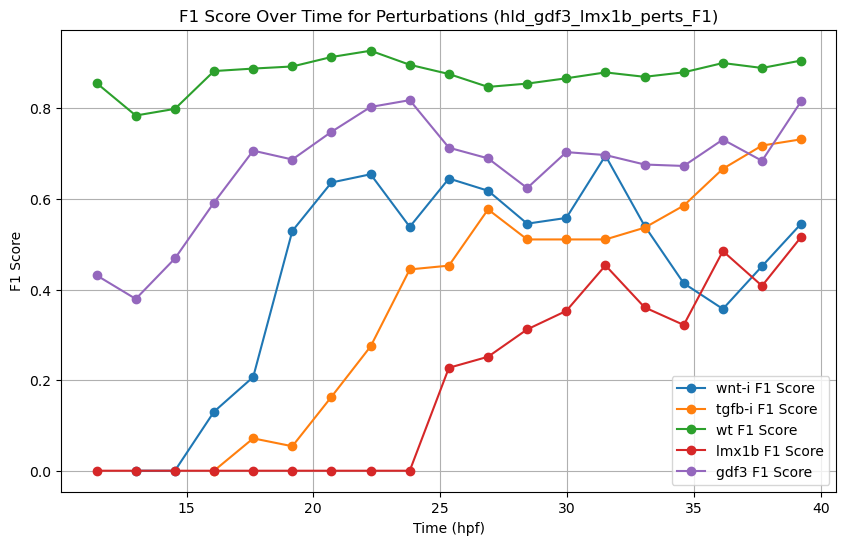

In [5]:
# an example
metric_loss_type = "NT-Xent"
margin = 1
metric_weight = 10
self_target_prob = 0.5
time_only_flag = 1
beta = 1


#~~~
holdout_flag = 0 

# boolean filter. NOTE THAT SOME COMBOS WILL NOT BE PRESENT (yet)
df_filter = (sweep_df["metric_loss_type"] == metric_loss_type) & (sweep_df["margin"] == margin) & (sweep_df["metric_weight"] == metric_weight) & \
            (sweep_df["self_target_prob"] == self_target_prob) & (sweep_df["time_only_flag"] == time_only_flag) & (sweep_df["holdout_flag"] == holdout_flag) & \
            (sweep_df["beta"] == beta)

# now, get training folder path
if np.any(df_filter):
    model_path = sweep_df.loc[df_filter, "model_path"].values[0]
    model_name = os.path.basename(model_path)
    # a couple of parameters for the model assessment script
    overwrite_flag = False # will skip if it detects the exprected output data already
    n_image_figures = 100  # make qualitative side-by-side reconstruction figures
    #had to change skip figures to true because i didnt have write access. 
    # assess_vae_results(root, train_fold
    
embryo_df_path = find_embryo_stats_csv(model_path)
if embryo_df_path is None:
    assess_vae_results(root, train_folder, model_name, n_image_figures=n_image_figures, 
    overwrite_flag=overwrite_flag, batch_size=64, skip_figures_flag=True)
    embryo_df_path = find_embryo_stats_csv(model_path)
    
df_all = pd.read_csv(embryo_df_path)

#~~~
holdout_flag = 1 

# boolean filter. NOTE THAT SOME COMBOS WILL NOT BE PRESENT (yet)
df_filter = (sweep_df["metric_loss_type"] == metric_loss_type) & (sweep_df["margin"] == margin) & (sweep_df["metric_weight"] == metric_weight) & \
            (sweep_df["self_target_prob"] == self_target_prob) & (sweep_df["time_only_flag"] == time_only_flag) & (sweep_df["holdout_flag"] == holdout_flag) & \
            (sweep_df["beta"] == beta)

# now, get training folder path
if np.any(df_filter):
    model_path = sweep_df.loc[df_filter, "model_path"].values[0]
    model_name = os.path.basename(model_path)
    # a couple of parameters for the model assessment script
    overwrite_flag = False # will skip if it detects the exprected output data already
    n_image_figures = 100  # make qualitative side-by-side reconstruction figures
    #had to change skip figures to true because i didnt have write access. 
    # assess_vae_results(root, train_fold
    
embryo_df_path = find_embryo_stats_csv(model_path)
if embryo_df_path is None:
    assess_vae_results(root, train_folder, model_name, n_image_figures=n_image_figures, 
    overwrite_flag=overwrite_flag, batch_size=64, skip_figures_flag=True)
    embryo_df_path = find_embryo_stats_csv(model_path)
df_hld = pd.read_csv(embryo_df_path)
#~~~



# Split the data
df_all_train, df_all_test, df_all = split_train_test(df_all)
df_hld_train, df_hld_test, df_hld = split_train_test(df_hld)

# Define the comparisons (Multiclass) and obtain coloumns for data
pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]

# --- Example usage with logistic_regression_multiclass (all suffix) ---
y_test_all, y_pred_proba_all, log_reg_all, train_df_all, test_df_all = logistic_regression_multiclass(
    df_all_train, df_all_test, z_mu_biological_columns, pert_comparisons)

# --- Example usage with logistic_regression_multiclass (hld suffix) ---
y_test_hld, y_pred_proba_hld, log_reg_hld, train_df_hld, test_df_hld = logistic_regression_multiclass(
    df_hld_train, df_hld_test, z_mu_biological_columns, pert_comparisons)


##all
results_dict_all = f1_score_over_time_multiclass(y_test_all, y_pred_proba_all, test_df_all, pert_comparisons, num_bins=20, max_hpf=40)
dataset_label = 'all_perts_F1'
plot_f1_score_over_time(results_dict_all, pert_comparisons, dataset_label=dataset_label, title="F1 Score Over Time for Perturbations")

#hld
results_dict_hld = f1_score_over_time_multiclass(y_test_hld, y_pred_proba_hld, test_df_hld, pert_comparisons, num_bins=20, max_hpf=40)
dataset_label = 'hld_gdf3_lmx1b_perts_F1'
plot_f1_score_over_time(results_dict_hld, pert_comparisons, dataset_label=dataset_label, title="F1 Score Over Time for Perturbations")



In [8]:

# Call the function
fig = plot_pca_highlighted_embryos(
    test_df=test_df_all,
    z_mu_biological_columns=z_mu_biological_columns,
    perturbations= pert_comparisons,
    marker_size=3,
    highlight_marker_size=5,
    opacity=0.3,
    title="Embryo PCA with Highlights",
    show_legend=True,
    plot=True
)

{'wt': '#1f77b4', 'wnt-i': '#ff7f0e', 'tgfb-i': '#2ca02c', 'lmx1b': '#d62728', 'gdf3': '#9467bd'}


In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import seaborn as sns  # Ensure seaborn is imported
from sklearn.decomposition import PCA
import plotly.graph_objs as go
import pandas as pd

def generate_distinct_color_mapping(perturbations):
    # Ensure 'wt' is the first perturbation if it exists
    if 'wt' in perturbations:
        perturbations = ['wt'] + [p for p in perturbations if p != 'wt']
    
    n = len(perturbations)

    colors = [mcolors.rgb2hex(clr) for clr in sns.color_palette(n_colors=n)]
    # Create a dictionary mapping each perturbation to a color
    color_mapping = dict(zip(perturbations, colors))
    
    return color_mapping

def plot_pca_highlighted_embryos(
    test_df,
    z_mu_biological_columns,
    perturbations=None,
    highlight_embryos=None,
    highlight_colors=None,
    marker_size=5,
    highlight_marker_size=10,
    opacity=0.7,
    title="3D PCA Plot",
    show_legend=True,
    plot=True,
    downsample_wt=False,          # Enable/disable downsampling
    wt_downsample_frac=0.1,       # Fraction of unique 'wt' embryo_ids to retain
    random_state=42               # Random state for reproducibility
):
    """
    Plots a 3D PCA of the provided test_df, highlighting specified embryos and connecting their points with lines.
    
    Parameters:
    - test_df (pd.DataFrame): DataFrame containing the data to plot.
    - z_mu_biological_columns (list): List of column names used for PCA.
    - perturbations (list, optional): List of perturbations to include. Defaults to None.
    - highlight_embryos (list, optional): List of embryo_ids to highlight. Defaults to None.
    - highlight_colors (dict, optional): Mapping of embryo_ids to colors for highlighting. Defaults to None.
    - marker_size (int, optional): Size of the markers. Defaults to 5.
    - highlight_marker_size (int, optional): Size of the highlighted markers. Defaults to 10.
    - opacity (float, optional): Opacity of the markers. Defaults to 0.7.
    - title (str, optional): Title of the plot. Defaults to "3D PCA Plot".
    - show_legend (bool, optional): Whether to display the legend. Defaults to True.
    - plot (bool, optional): Whether to display the plot. Defaults to True.
    - downsample_wt (bool, optional): Whether to downsample 'wt' data by unique 'embryo_id's. Defaults to False.
    - wt_downsample_frac (float, optional): Fraction of unique 'wt' embryo_ids to retain if downsampling is enabled. Defaults to 0.1.
    - random_state (int, optional): Seed for random number generator to ensure reproducibility. Defaults to 42.
    
    Returns:
    - plotly.graph_objs._figure.Figure: The generated Plotly figure.
    
    Raises:
    - ValueError: If required columns are missing or if downsampling results in an empty dataset.
    """
    # Validate input columns
    required_columns = set(["phenotype", "embryo_id", "snip_id", "predicted_stage_hpf"] + z_mu_biological_columns)
    missing_columns = required_columns - set(test_df.columns)
    if missing_columns:
        raise ValueError(f"The following required columns are missing from test_df: {missing_columns}")
    
    # Generate color mapping
    color_mapping = generate_distinct_color_mapping(perturbations)
    print("Color Mapping:", color_mapping)
    
    # Filter the DataFrame based on specified perturbations
    combined_df = test_df[test_df["phenotype"].isin(perturbations)].copy()
    
    if combined_df.empty:
        raise ValueError("No data available for the specified perturbations.")
    
    # Downsampling 'wt' by unique 'embryo_id's if enabled
    if downsample_wt and 'wt' in perturbations:
        wt_df = combined_df[combined_df['phenotype'] == 'wt']
        non_wt_df = combined_df[combined_df['phenotype'] != 'wt']
        
        unique_wt_embryo_ids = wt_df['embryo_id'].unique()
        total_unique_wt = len(unique_wt_embryo_ids)
        
        # Calculate the number of unique embryo_ids to retain
        n_unique_wt_downsampled = max(1, int(total_unique_wt * wt_downsample_frac))
        
        # Perform random sampling of unique embryo_ids without replacement
        sampled_wt_embryo_ids = pd.Series(unique_wt_embryo_ids).sample(
            n=n_unique_wt_downsampled, 
            random_state=random_state
        ).tolist()
        
        # Filter 'wt' DataFrame to include only sampled embryo_ids
        wt_downsampled = wt_df[wt_df['embryo_id'].isin(sampled_wt_embryo_ids)]
        
        # Combine back with non-'wt' data
        combined_df = pd.concat([non_wt_df, wt_downsampled], ignore_index=True)
        
        print(f"Downsampled 'wt' embryo_ids from {total_unique_wt} to {n_unique_wt_downsampled} unique IDs.")
        print(f"Total 'wt' samples after downsampling: {len(wt_downsampled)}")
    
    # Check if downsampling resulted in an empty DataFrame
    if combined_df.empty:
        raise ValueError("Downsampling resulted in an empty dataset. Adjust the downsampling fraction or check the data.")
    
    # Subset the z_mu_biological_columns for PCA
    z_mu_data = combined_df[z_mu_biological_columns]
    
    # Perform PCA
    pca = PCA(n_components=3)
    pca_embedding = pca.fit_transform(z_mu_data)
    
    # Calculate explained variance
    explained_variance_ratio = pca.explained_variance_ratio_
    explained_variance_percentage = 100 * explained_variance_ratio.sum()
    
    # Add PCA results to the DataFrame
    for i in range(3):
        combined_df[f"PCA{i+1}"] = pca_embedding[:, i]
    
    # Initialize Plotly figure
    fig = go.Figure()
    
    # Loop over perturbations and add a trace for each
    for pert in perturbations:
        pert_df = combined_df[combined_df['phenotype'] == pert]
        if pert_df.empty:
            continue
        fig.add_trace(
            go.Scatter3d(
                x=pert_df["PCA1"],
                y=pert_df["PCA2"],
                z=pert_df["PCA3"],
                mode='markers',
                marker=dict(
                    color=color_mapping[pert],
                    size=marker_size,
                    opacity=opacity
                ),
                customdata=pert_df[['embryo_id', 'phenotype', "snip_id", "predicted_stage_hpf"]],
                hovertemplate=(
                    'Embryo ID: %{customdata[0]}<br>'
                    'Perturbation: %{customdata[1]}<br>'
                    'Snip ID: %{customdata[2]}<br>'
                    'Predicted hpf: %{customdata[3]:.2f}<extra></extra>'
                ),
                name=pert,
                showlegend=show_legend
            )
        )
    
    # Update axis labels with explained variance
    axis_titles = {}
    for i in range(3):
        axis_titles[f"PCA{i+1}"] = f"PCA {i+1} ({explained_variance_ratio[i]*100:.2f}% variance)"
    
    fig.update_layout(
        scene=dict(
            xaxis_title=axis_titles.get("PCA1", "PCA 1"),
            yaxis_title=axis_titles.get("PCA2", "PCA 2"),
            zaxis_title=axis_titles.get("PCA3", "PCA 3"),
        ),
        title=f"{title} ({explained_variance_percentage:.2f}% variance explained)",
        margin=dict(l=0, r=0, b=0, t=50),
        legend=dict(
            itemsizing='constant'
        )
    )
    
    # Highlight specified embryos if provided
    if highlight_embryos:
        for embryo_id, color in zip(highlight_embryos, highlight_colors):
            embryo_df = combined_df[combined_df['embryo_id'] == embryo_id]
            if embryo_df.empty:
                continue
            fig.add_trace(
                go.Scatter3d(
                    x=embryo_df["PCA1"],
                    y=embryo_df["PCA2"],
                    z=embryo_df["PCA3"],
                    mode='markers+lines',
                    marker=dict(
                        color=color,
                        size=highlight_marker_size,
                        opacity=1.0
                    ),
                    line=dict(
                        color=color,
                        width=4
                    ),
                    name=f'Highlight: {embryo_id}',
                    showlegend=False
                )
            )
    
    # Show the plot
    if plot:
        fig.show()
    
    return fig

In [ ]:
# Call the function
fig = plot_pca_highlighted_embryos(
    test_df=test_df_hld,
    z_mu_biological_columns=z_mu_biological_columns,
    perturbations= pert_comparisons,
    marker_size=3,
    highlight_marker_size=5,
    opacity=0.3,
    title="Embryo PCA with Highlights",
    show_legend=True,
    plot=True,
    wt_downsample_frac=0.01
)

Color Mapping: {'wt': '#1f77b4', 'wnt-i': '#ff7f0e', 'tgfb-i': '#2ca02c', 'lmx1b': '#d62728', 'gdf3': '#9467bd'}


In [16]:
# an example
metric_loss_type = "NT-Xent"
margin = 1
metric_weight = 10
self_target_prob = 0.5
time_only_flag = 1
beta = 1


#~~~
holdout_flag = 0 

# boolean filter. NOTE THAT SOME COMBOS WILL NOT BE PRESENT (yet)
df_filter = (sweep_df["metric_loss_type"] == metric_loss_type) & (sweep_df["margin"] == margin) & (sweep_df["metric_weight"] == metric_weight) & \
            (sweep_df["self_target_prob"] == self_target_prob) & (sweep_df["time_only_flag"] == time_only_flag) & (sweep_df["holdout_flag"] == holdout_flag) & \
            (sweep_df["beta"] == beta)

# now, get training folder path
if np.any(df_filter):
    model_path = sweep_df.loc[df_filter, "model_path"].values[0]
    model_name = os.path.basename(model_path)
    # a couple of parameters for the model assessment script
    overwrite_flag = False # will skip if it detects the exprected output data already
    n_image_figures = 100  # make qualitative side-by-side reconstruction figures
    #had to change skip figures to true because i didnt have write access. 
    # assess_vae_results(root, train_fold


embryo_df_path = find_embryo_stats_csv(model_path)
if embryo_df_path is None:
    assess_vae_results(root, train_folder, model_name, n_image_figures=n_image_figures, 
    overwrite_flag=overwrite_flag, batch_size=64, skip_figures_flag=True)
    embryo_df_path = find_embryo_stats_csv(model_path)
    
print(embryo_df_path)
print(model_path)

#~~~
holdout_flag = 1 

# boolean filter. NOTE THAT SOME COMBOS WILL NOT BE PRESENT (yet)
df_filter = (sweep_df["metric_loss_type"] == metric_loss_type) & (sweep_df["margin"] == margin) & (sweep_df["metric_weight"] == metric_weight) & \
            (sweep_df["self_target_prob"] == self_target_prob) & (sweep_df["time_only_flag"] == time_only_flag) & (sweep_df["holdout_flag"] == holdout_flag) & \
            (sweep_df["beta"] == beta)

# now, get training folder path
if np.any(df_filter):
    model_path = sweep_df.loc[df_filter, "model_path"].values[0]
    model_name = os.path.basename(model_path)
    # a couple of parameters for the model assessment script
    overwrite_flag = False # will skip if it detects the exprected output data already
    n_image_figures = 100  # make qualitative side-by-side reconstruction figures
    #had to change skip figures to true because i didnt have write access. 
    # assess_vae_results(root, train_fold
    
embryo_df_path = find_embryo_stats_csv(model_path)
if embryo_df_path is None:
    assess_vae_results(root, train_folder, model_name, n_image_figures=n_image_figures, 
    overwrite_flag=overwrite_flag, batch_size=64, skip_figures_flag=True)
    embryo_df_path = find_embryo_stats_csv(model_path)


print(embryo_df_path)
print(model_path)
#~~~


/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block00_iter009/SeqVAE_training_2024-11-09_09-42-28/figures/embryo_stats_df.csv
/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block00_iter009
/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block00_iter009/SeqVAE_training_2024-11-09_09-42-28/figures/embryo_stats_df.csv
/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block00_iter009


In [20]:
# an example
metric_loss_type = "NT-Xent"
margin = 1
metric_weight = 10
self_target_prob = 0.5
time_only_flag = 1
beta = 1


#~~~
holdout_flag = 0 

# boolean filter. NOTE THAT SOME COMBOS WILL NOT BE PRESENT (yet)
df_filter = (sweep_df["metric_loss_type"] == metric_loss_type) & (sweep_df["margin"] == margin) & (sweep_df["metric_weight"] == metric_weight) & \
            (sweep_df["self_target_prob"] == self_target_prob) & (sweep_df["time_only_flag"] == time_only_flag) & (sweep_df["holdout_flag"] == holdout_flag) & \
            (sweep_df["beta"] == beta)

# now, get training folder path
if np.any(df_filter):
    model_path = sweep_df.loc[df_filter, "model_path"].values[0]
    model_name = os.path.basename(model_path)
    # a couple of parameters for the model assessment script
    overwrite_flag = False # will skip if it detects the exprected output data already
    n_image_figures = 100  # make qualitative side-by-side reconstruction figures
    #had to change skip figures to true because i didnt have write access. 
    # assess_vae_results(root, train_fold


embryo_df_path = find_embryo_stats_csv(model_path)
if embryo_df_path is None:
    assess_vae_results(root, train_folder, model_name, n_image_figures=n_image_figures, 
    overwrite_flag=overwrite_flag, batch_size=64, skip_figures_flag=True)
    embryo_df_path = find_embryo_stats_csv(model_path)
    
print(embryo_df_path)
print(model_path)

/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block00_iter009/SeqVAE_training_2024-11-09_09-42-28/figures/embryo_stats_df.csv
/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block00_iter009


In [22]:
sweep_df.loc[df_filter, :]

metric_loss_type  margin  metric_weight  self_target_prob  time_only_flag  \
9          NT-Xent     1.0             10               0.5               1   

   temperature  learning_rate  latent_dim  beta  batch_size  zn_frac  \
9          0.1         0.0001         100   1.0        2048      0.2   

   holdout_flag                                         model_path  completed  \
9             0  /net/trapnell/vol1/home/nlammers/projects/data...          1   

   process_id  
9          33

In [26]:

#~~~
holdout_flag = 1 

# boolean filter. NOTE THAT SOME COMBOS WILL NOT BE PRESENT (yet)
df_filter = (sweep_df["metric_loss_type"] == metric_loss_type) & (sweep_df["margin"] == margin) & (sweep_df["metric_weight"] == metric_weight) & \
            (sweep_df["self_target_prob"] == self_target_prob) & (sweep_df["time_only_flag"] == time_only_flag) & (sweep_df["holdout_flag"] == holdout_flag) & \
            (sweep_df["beta"] == beta)

# now, get training folder path
if np.any(df_filter):
    model_path = sweep_df.loc[df_filter, "model_path"].values[0]
    model_name = os.path.basename(model_path)
    # a couple of parameters for the model assessment script
    overwrite_flag = False # will skip if it detects the exprected output data already
    n_image_figures = 100  # make qualitative side-by-side reconstruction figures
    #had to change skip figures to true because i didnt have write access. 
    # assess_vae_results(root, train_fold
    
embryo_df_path = find_embryo_stats_csv(model_path)
if embryo_df_path is None:
    assess_vae_results(root, train_folder, model_name, n_image_figures=n_image_figures, 
    overwrite_flag=overwrite_flag, batch_size=64, skip_figures_flag=True)
    embryo_df_path = find_embryo_stats_csv(model_path)


print(embryo_df_path)
print(model_path)
#~~~
sweep_df.loc[df_filter, :]

/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block00_iter009/SeqVAE_training_2024-11-09_09-42-28/figures/embryo_stats_df.csv
/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block00_iter009


Empty DataFrame
Columns: [metric_loss_type, margin, metric_weight, self_target_prob, time_only_flag, temperature, learning_rate, latent_dim, beta, batch_size, zn_frac, holdout_flag, model_path, completed, process_id]
Index: []

In [29]:
list(sweep_df.columns)

['metric_loss_type',
 'margin',
 'metric_weight',
 'self_target_prob',
 'time_only_flag',
 'temperature',
 'learning_rate',
 'latent_dim',
 'beta',
 'batch_size',
 'zn_frac',
 'holdout_flag',
 'model_path',
 'completed',
 'process_id']

In [50]:
import pandas as pd
import os

# Subset the dataframe to only include completed entries
completed_df = sweep_df[sweep_df['completed'] == True].copy()

def find_embryo_stats_csv(model_path):
    target_file = 'embryo_stats_df.csv'
    for root, dirs, files in os.walk(model_path):
        if target_file in files and 'figures' in root:
            return os.path.join(root, target_file)
    return None

def get_embryo_df_path(model_path):
    embryo_df_path = find_embryo_stats_csv(model_path)
    
    if embryo_df_path is None:
        print(f"File 'embryo_stats_df.csv' not found under {model_path}")
        print("Attempting to generate 'embryo_stats_df.csv'...")
        
        path_parts = model_path.strip(os.sep).split(os.sep)
        
        try:
            model_name = os.path.basename(model_path)
            # a couple of parameters for the model assessment script
            overwrite_flag = False # will skip if it detects the exprected output data already
            n_image_figures = 100  # make qualitative side-by-side reconstruction figures
            assess_vae_results(root, train_folder, model_name, n_image_figures=n_image_figures, overwrite_flag=overwrite_flag, batch_size=64, skip_figures_flag=True)

            # Try to find the 'embryo_stats_df.csv' again
            embryo_df_path = find_embryo_stats_csv(model_path)
            
            if embryo_df_path is None:
                print(f"Failed to generate 'embryo_stats_df.csv' under {model_path}")
        except ValueError:
            print(f"Could not parse 'model_path' to extract necessary components: {model_path}")
            embryo_df_path = None
        except ImportError:
            print("Could not import 'assess_vae_results'. Please ensure it is correctly imported.")
            embryo_df_path = None
        except Exception as e:
            print(f"An error occurred while generating 'embryo_stats_df.csv': {e}")
            embryo_df_path = None
    return embryo_df_path

# Apply the function to generate the 'embryo_df_path' column
completed_df['embryo_df_path'] = completed_df['model_path'].apply(find_embryo_stats_csv) # change to get_embryo_df_path when you want to calc the embryo_df

# Filter out any entries where 'embryo_df_path' is still None
completed_df = completed_df[completed_df['embryo_df_path'].notnull()]

parameter_cols = [
    'metric_loss_type',
    'margin',
    'metric_weight',
    'self_target_prob',
    'time_only_flag',
    'temperature',
    'learning_rate',
    'latent_dim',
    'beta',
    'batch_size',
    'zn_frac'
]

# Group the dataframe by parameter columns
grouped = completed_df.groupby(parameter_cols)

# Initialize a list to collect new rows
new_rows = []

# Iterate over each group
for group_keys, group_df in grouped:
    holdout_flags = group_df['holdout_flag'].unique()
    # Check if both holdout_flag values 0 and 1 are present
    if set(holdout_flags) == {0, 1}:
        # Extract rows for holdout_flag 0 and 1
        hld_row = group_df[group_df['holdout_flag'] == 1].iloc[0]
        nohld_row = group_df[group_df['holdout_flag'] == 0].iloc[0]
        
        # Create a new row with shared parameters and separate paths
        new_row = dict(zip(parameter_cols, group_keys))
        new_row['model_path_hld'] = hld_row['model_path']
        new_row['model_path_nohld'] = nohld_row['model_path']
        new_row['embryo_df_path_hld'] = hld_row['embryo_df_path']
        new_row['embryo_df_path_nohld'] = nohld_row['embryo_df_path']
        
        new_rows.append(new_row)

# Create a new dataframe from the list of new rows
paired_models_df = pd.DataFrame(new_rows)

# Remove rows where 'embryo_df_path_hld' or 'embryo_df_path_nohld' is None
paired_models_df = paired_models_df[
    paired_models_df['embryo_df_path_hld'].notnull() &
    paired_models_df['embryo_df_path_nohld'].notnull()
]

# Ensure 'embryo_df_path_hld' and 'embryo_df_path_nohld' are not the same
duplicates = paired_models_df[paired_models_df['embryo_df_path_hld'] == paired_models_df['embryo_df_path_nohld']]
if not duplicates.empty:
    print("Duplicate embryo_df_path found in the following rows:\n", duplicates)

# Remove rows with duplicate paths
paired_models_df = paired_models_df[paired_models_df['embryo_df_path_hld'] != paired_models_df['embryo_df_path_nohld']]

In [46]:
print(paired_models_df.iloc[0]["model_path_hld"])
print(paired_models_df.iloc[0]["model_path_nohld"])

/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block04_iter000
/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block01_iter000


In [48]:

paired_models_df.iloc[0]["embryo_df_path_hld"]
paired_models_df.iloc[0]["embryo_df_path_nohld"]


/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block04_iter000/SeqVAE_training_2024-11-08_14-07-59/figures/embryo_stats_df.csv
/net/trapnell/vol1/home/nlammers/projects/data/morphseq/training_data/20241107_ds/SeqVAE_z100_ne150_sweep_01_block01_iter000/SeqVAE_training_2024-11-08_14-07-53/figures/embryo_stats_df.csv


/tmp/6509408.1.trapnell-login.q/ipykernel_1521002/195350234.py:1: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/6509408.1.trapnell-login.q/ipykernel_1521002/195350234.py:2: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:112: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:113: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docum

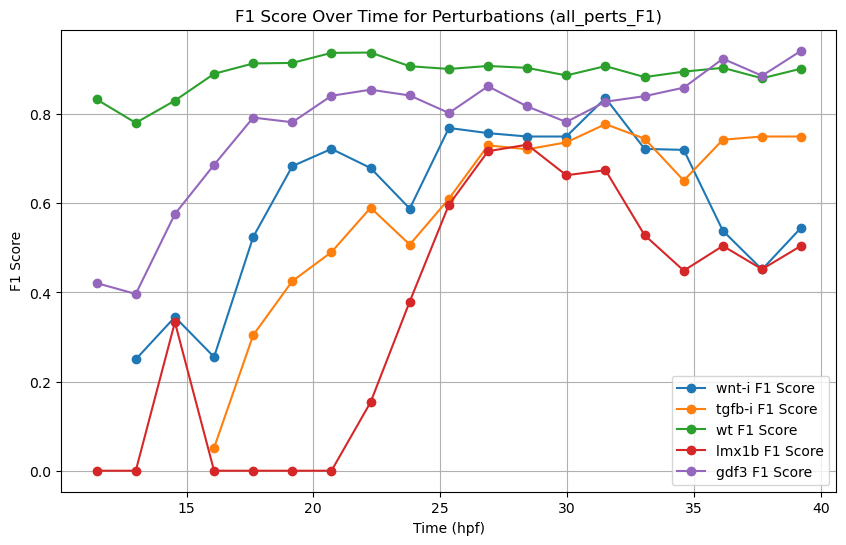

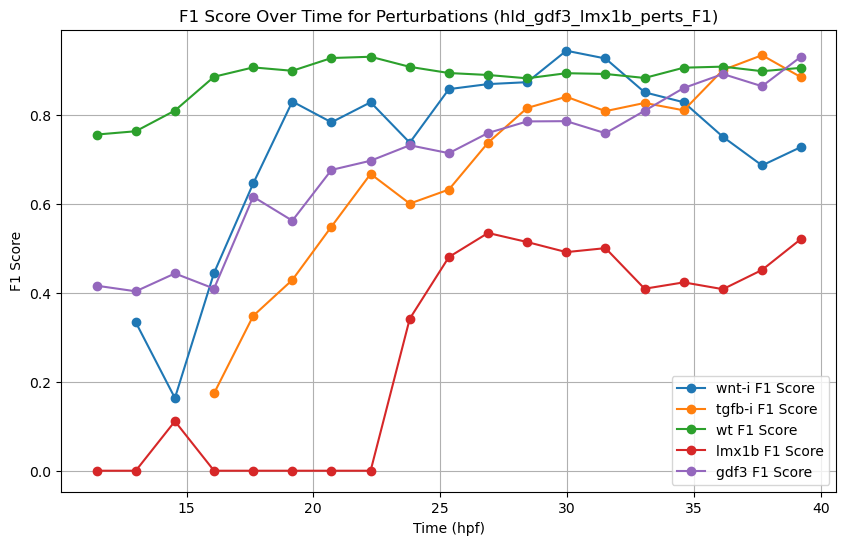

In [51]:

    
df_all = pd.read_csv(paired_models_df.iloc[0]["embryo_df_path_nohld"])
df_hld = pd.read_csv(paired_models_df.iloc[0]["embryo_df_path_hld"])




# Split the data
df_all_train, df_all_test, df_all = split_train_test(df_all)
df_hld_train, df_hld_test, df_hld = split_train_test(df_hld)

# Define the comparisons (Multiclass) and obtain coloumns for data
pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]

# --- Example usage with logistic_regression_multiclass (all suffix) ---
y_test_all, y_pred_proba_all, log_reg_all, train_df_all, test_df_all = logistic_regression_multiclass(
    df_all_train, df_all_test, z_mu_biological_columns, pert_comparisons)

# --- Example usage with logistic_regression_multiclass (hld suffix) ---
y_test_hld, y_pred_proba_hld, log_reg_hld, train_df_hld, test_df_hld = logistic_regression_multiclass(
    df_hld_train, df_hld_test, z_mu_biological_columns, pert_comparisons)


##all
results_dict_all = f1_score_over_time_multiclass(y_test_all, y_pred_proba_all, test_df_all, pert_comparisons, num_bins=20, max_hpf=40)
dataset_label = 'all_perts_F1'
plot_f1_score_over_time(results_dict_all, pert_comparisons, dataset_label=dataset_label, title="F1 Score Over Time for Perturbations")

#hld
results_dict_hld = f1_score_over_time_multiclass(y_test_hld, y_pred_proba_hld, test_df_hld, pert_comparisons, num_bins=20, max_hpf=40)
dataset_label = 'hld_gdf3_lmx1b_perts_F1'
plot_f1_score_over_time(results_dict_hld, pert_comparisons, dataset_label=dataset_label, title="F1 Score Over Time for Perturbations")



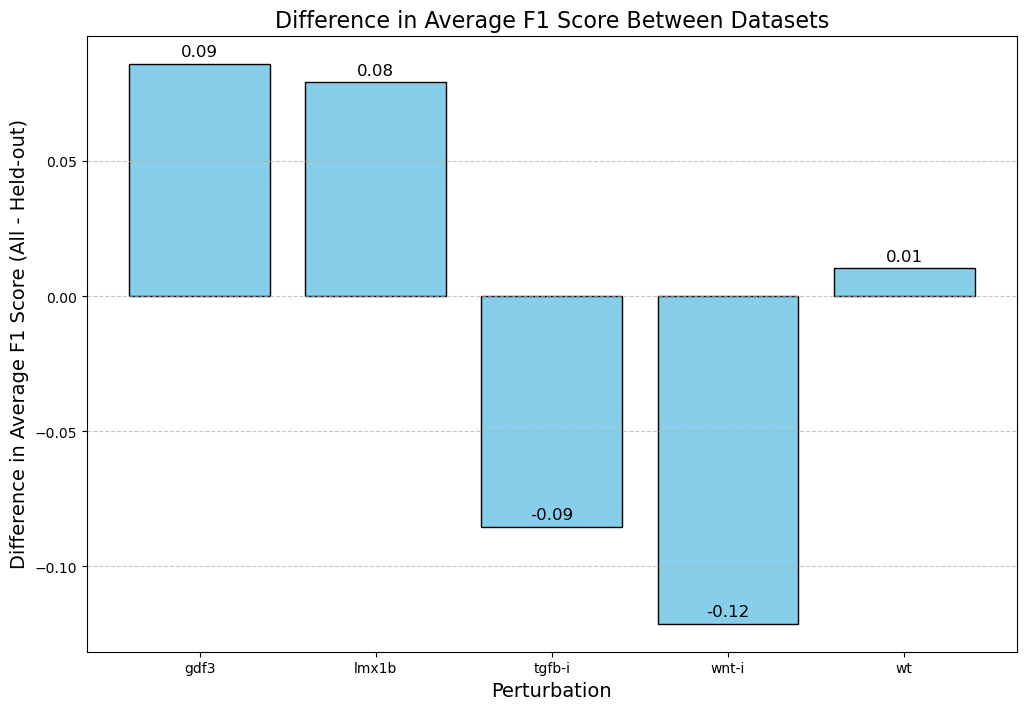

In [54]:
# --- Main Processing ---
# Step 1: Create per-bin F1 score dataframe
f1_score_df = create_f1_score_dataframe(results_dict_all, results_dict_hld, pert_comparisons)

# # Step 2: Compute average F1 scores and differences
avg_f1_score_df = compute_average_f1_score(f1_score_df)

# # Step 3: Plot the differences in average F1 scores
plot_average_f1_score_difference(avg_f1_score_df)

In [ ]:
# List of DataFrames and titles for processing
z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]

dataframes = [
    (df_all, 'Original Data'),
    (df_hld, 'No lmx1b gdf3')
]

random_state = 100

# List of perturbations to process
pert_comparisons

# Subsample fraction
subsample_fraction = 0.05  # Adjust as needed
# Compute the metrics

metrics_intra_df, metrics_inter_df = compute_metrics_for_dataframes(
    dataframes=dataframes,
    comparisons=pert_comparisons,
    subsample_fraction=subsample_fraction,
    random_state=random_state
)

# Compute the differences
diff_intra, diff_inter = compute_differences(
    metrics_intra_df,
    metrics_inter_df,
    reference_title='Original Data',
    comparison_title='No lmx1b gdf3'
)


# # Plot differences together for intra-perturbation
# plot_differences_together(diff_intra, 'Intra')

# # Plot differences together for inter-perturbation
# plot_differences_together(diff_inter, 'Inter')

In [73]:

def compute_metrics_for_dataframes(dataframes, comparisons, subsample_fraction=0.05, random_state=100,z_mu_biological_columns=z_mu_biological_columns):
    """
    Compute metrics for given dataframes and comparisons.

    Parameters:
    - dataframes: List of tuples (DataFrame, title)
    - comparisons: List of perturbations to process
    - subsample_fraction: Fraction of data to subsample
    - random_state: Seed for reproducibility

    Returns:
    - metrics_intra_df: DataFrame containing intra-perturbation metrics
    - metrics_inter_df: DataFrame containing inter-perturbation metrics
    """
    # Prepare dictionaries to store results
    reference_histograms = {'intra': {}, 'inter': {}}
    metrics_intra_list = []
    metrics_inter_list = []

    # Loop over intra- and inter-perturbation distances
    for distance_type in ['intra', 'inter']:
        # Loop over each DataFrame and its title
        for df_idx, (df, df_title) in enumerate(dataframes):
            # Sample data for all perturbations
            subsampled_data = {}
            for perturbation in comparisons:
                df_pert = df[df['phenotype'] == perturbation].copy()
                if df_pert.empty:
                    # Skip perturbations not present in the DataFrame
                    continue
                embryo_ids = df_pert['embryo_id'].unique()

                # Initialize a list to store samples from each embryo_id
                samples_per_embryo = []

                for embryo_id in embryo_ids:
                    df_embryo = df_pert[df_pert['embryo_id'] == embryo_id]
                    # Ensure at least one data point is sampled from each embryo_id
                    n_samples = max(int(len(df_embryo) * subsample_fraction), 1)
                    df_embryo_sampled = df_embryo.sample(n=n_samples, random_state=random_state)
                    samples_per_embryo.append(df_embryo_sampled)

                # Combine samples from all embryo_ids for this perturbation
                df_pert_sampled = pd.concat(samples_per_embryo, ignore_index=True)
                subsampled_data[perturbation] = df_pert_sampled

            # Combine all subsampled data into a global dataset
            df_sampled = pd.concat(subsampled_data.values(), ignore_index=True)
            z_mu_data_sampled = df_sampled[z_mu_biological_columns].values
            # Compute global mean and std for z-scoring
            full_distances_sampled = pdist(z_mu_data_sampled, metric='euclidean')
            mean_dist = np.mean(full_distances_sampled)
            std_dist = np.std(full_distances_sampled)

            # Loop over the perturbations to compare
            for perturbation in comparisons:
                if perturbation not in subsampled_data:
                    continue  # Skip if perturbation data is missing

                df_pert_sampled = subsampled_data[perturbation]
                z_mu_data_pert = df_pert_sampled[z_mu_biological_columns].values

                # Ensure there are enough points
                if len(z_mu_data_pert) < 2:
                    continue

                if distance_type == 'intra':
                    # Intra-perturbation distances
                    distances = pdist(z_mu_data_pert, metric='euclidean')
                    z_mu_data_for_metrics = z_mu_data_pert  # For graph metrics
                else:
                    # Inter-perturbation distances
                    # Sample points from other perturbations
                    other_perturbations = [p for p in comparisons if p != perturbation and p in subsampled_data]
                    if not other_perturbations:
                        continue
                    df_other = pd.concat([subsampled_data[p] for p in other_perturbations], ignore_index=True)
                    z_mu_data_other = df_other[z_mu_biological_columns].values

                    # Ensure same number of points
                    n_samples = len(z_mu_data_pert)
                    if len(z_mu_data_other) > n_samples:
                        indices = np.random.choice(len(z_mu_data_other), n_samples, replace=False)
                        z_mu_data_other = z_mu_data_other[indices]
                    elif len(z_mu_data_other) < 2:
                        continue

                    # Compute distances between z_mu_data_pert and z_mu_data_other
                    distances = cdist(z_mu_data_pert, z_mu_data_other, metric='euclidean').flatten()
                    # For graph metrics, combine both datasets
                    z_mu_data_for_metrics = np.vstack((z_mu_data_pert, z_mu_data_other))

                # Z-score distances
                distances_z = (distances - mean_dist) / std_dist

                # Compute metrics
                metrics = compute_graph_metrics(z_mu_data_for_metrics)

                # Compute histogram and KL divergence
                # Use the same bin edges across all datasets for consistency
                if df_title == 'Original Data':
                    # Compute histogram counts and bin edges for the reference dataset
                    counts, bin_edges = compute_histogram(distances_z, bins=30)
                    # Store the reference histogram
                    reference_histograms[distance_type][perturbation] = {'counts': counts, 'bin_edges': bin_edges}
                    KL_div = 0.0  # KL divergence is zero for the reference
                else:
                    # Use the reference histogram's bin edges
                    ref_hist = reference_histograms[distance_type].get(perturbation)
                    if ref_hist is None:
                        continue

                    bin_edges = ref_hist['bin_edges']

                    # Compute histogram counts using the same bin edges
                    counts, _ = np.histogram(distances_z, bins=bin_edges, density=True)

                    # Compute KL divergence
                    KL_div = compute_kl_divergence(ref_hist['counts'], counts)

                # Store metrics in the appropriate list
                metrics_entry = {
                    'DataFrame': df_title,
                    'Perturbation': perturbation,
                    'Avg_Path_Length': metrics['avg_path_length'],
                    'Clustering_Coeff': metrics['clustering_coeff'],
                    'KL_Divergence': KL_div
                }

                if distance_type == 'intra':
                    metrics_intra_list.append(metrics_entry)
                else:
                    metrics_inter_list.append(metrics_entry)

    # Convert the lists of metrics to DataFrames
    metrics_intra_df = pd.DataFrame(metrics_intra_list)
    metrics_inter_df = pd.DataFrame(metrics_inter_list)

    return metrics_intra_df, metrics_inter_df
# Functions to compute metrics
def compute_graph_metrics(z_mu_data):
    """
    Compute graph metrics for the given data.
    """
    k_neighbors = 10
    knn = NearestNeighbors(n_neighbors=min(k_neighbors, len(z_mu_data)))
    knn.fit(z_mu_data)
    knn_graph = knn.kneighbors_graph(z_mu_data, mode='connectivity')
    G = nx.Graph(knn_graph)

    metrics = {}
    if nx.is_connected(G):
        metrics['avg_path_length'] = nx.average_shortest_path_length(G)
    else:
        # Compute metrics on the largest connected component
        largest_cc = max(nx.connected_components(G), key=len)
        subgraph = G.subgraph(largest_cc).copy()
        metrics['avg_path_length'] = nx.average_shortest_path_length(subgraph)
    metrics['clustering_coeff'] = nx.average_clustering(G)
    return metrics


In [67]:
import networkx as nx
from sklearn.neighbors import NearestNeighbors
from scipy.spatial.distance import pdist, cdist

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3


/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:1426: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:1439: UserWarning:

FixedFormatter should only be used together with FixedLocator

/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:1447: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:1460: UserWarning:

FixedFormatter should only be used together with FixedLocator

/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:1468: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.


/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo

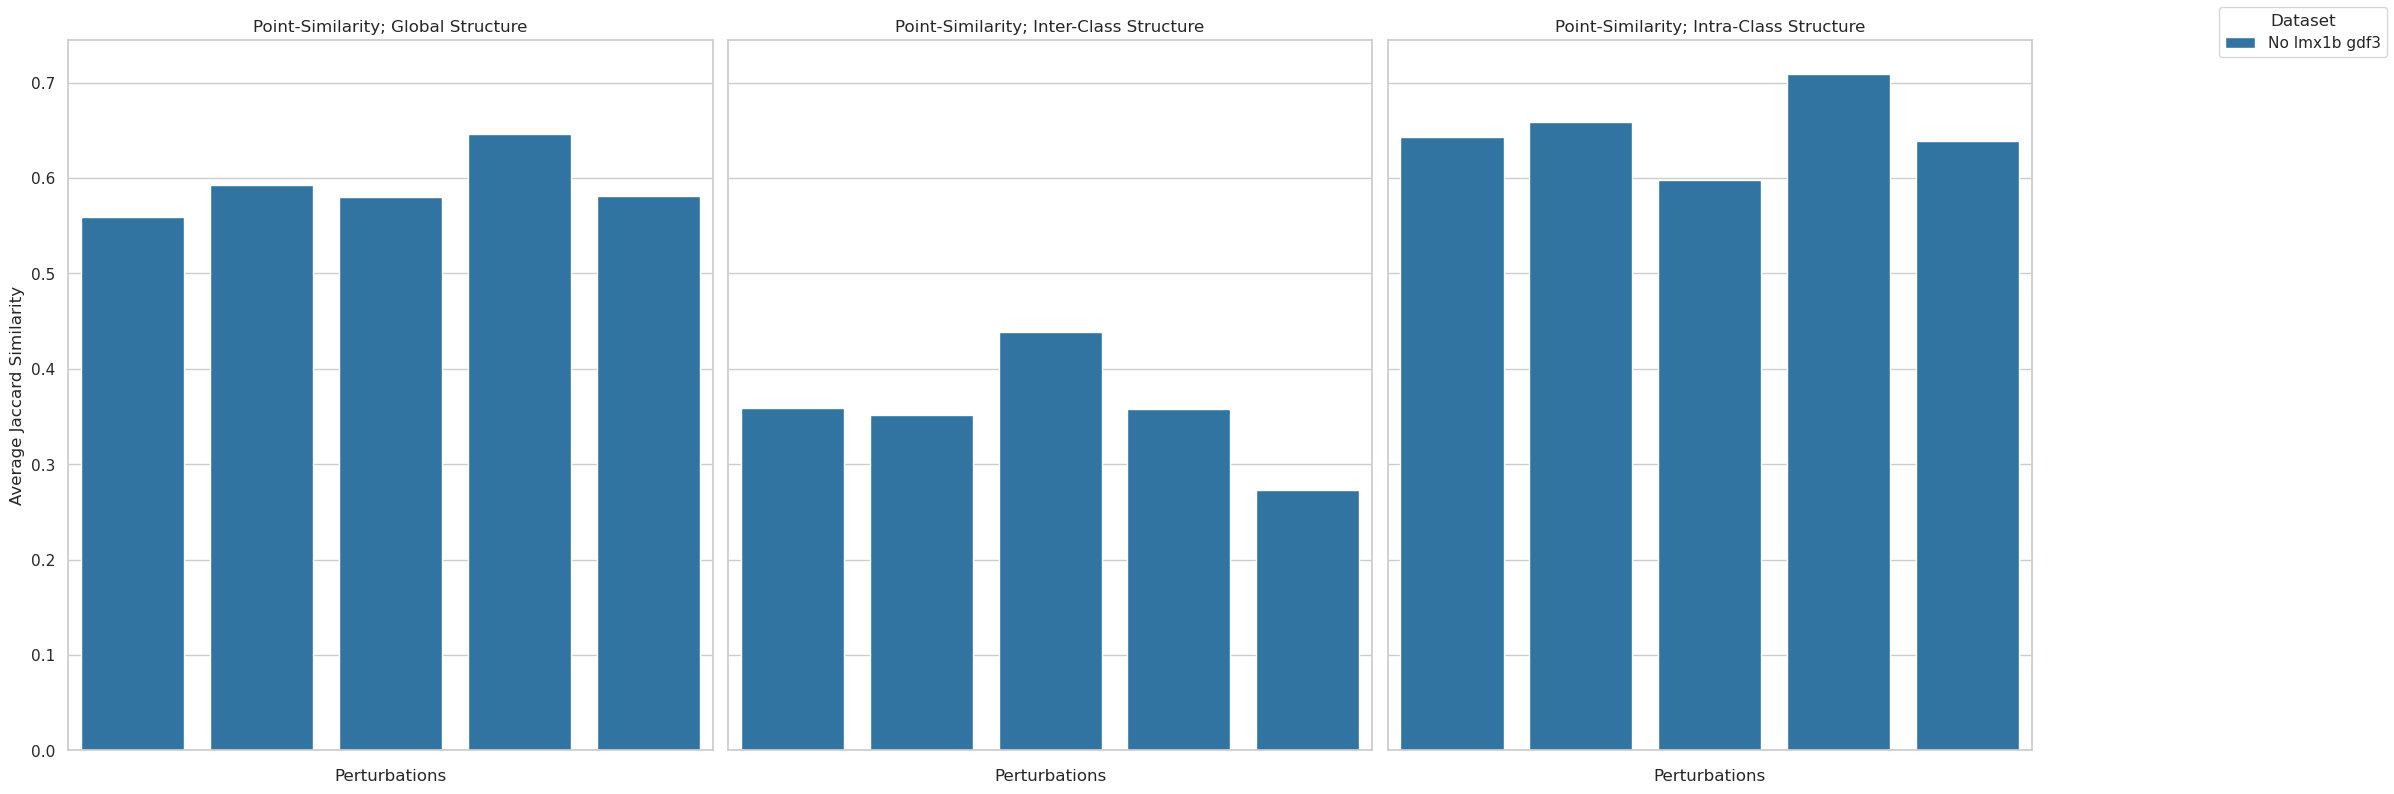

In [76]:
# Set number of neighbors (k) and subsample fraction
k_neighbors = 5
subsample_fraction = 0.1  # Adjust as needed

# List of DataFrames and titles for comparison
dataframes = [
    (df_hld, 'No lmx1b gdf3')
]


# Usage example:

# Compute the Jaccard similarities and get the separate results DataFrames
results_df_global, results_df_inter, results_df_intra = compute_jaccard_similarities(
    orig_df=df_all,
    dataframes=dataframes,
    comparisons=pert_comparisons,
    z_mu_biological_columns=z_mu_biological_columns,
    k_neighbors=k_neighbors,
    subsample_fraction=subsample_fraction
)

# Plot the results
plot_jaccard_results(results_df_global, results_df_inter, results_df_intra)

In [77]:
# Add suffix "_inter" to columns in metrics_inter_df if they don't already have it
results_df_global.columns = [
    f"{col}_global" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_global") else col
    for col in results_df_global.columns
]

results_df_intra.columns = [
    f"{col}_intra" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_intra") else col
    for col in results_df_intra.columns
]

# Add suffix "_inter" to columns in metrics_inter_df if they don't already have it
results_df_inter.columns = [
    f"{col}_inter" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_inter") else col
    for col in results_df_inter.columns
]


# Combining and Saving Performance Metrics

In [78]:
# List of dataframes to merge
dfs_to_merge = [avg_f1_score_df, diff_intra, diff_inter, results_df_global, results_df_intra, results_df_inter]

# Set 'Perturbation' as the index and drop 'DataFrame' columns
dfs_to_merge = [df.set_index('Perturbation').drop(columns='DataFrame', errors='ignore') for df in dfs_to_merge]

# Merge all dataframes on the 'Perturbation' index
core_performance_metrics = pd.concat(dfs_to_merge, axis=1)

# Reset index if needed
core_performance_metrics.reset_index(inplace=True)

core_performance_metrics

Perturbation  F1_score_all  F1_score_hld  F1_all_hld_diff  \
0         gdf3      0.775833      0.689668         0.086165   
1        lmx1b      0.352060      0.272774         0.079286   
2       tgfb-i      0.599046      0.684310        -0.085264   
3        wnt-i      0.604939      0.726150        -0.121211   
4           wt      0.890704      0.880263         0.010441   

   Avg_Path_Length_Diff  Clustering_Coeff_Diff  KL_Divergence_Diff  \
0             -0.151479               0.001028            0.070916   
1              0.106143               0.005817            0.002362   
2             -0.069455               0.004108            0.004832   
3              0.094444               0.039674            0.019016   
4              0.269296               0.002721            0.002740   

   Avg_Path_Length_Diff  Clustering_Coeff_Diff  KL_Divergence_Diff  \
0              0.066360               0.002067            0.032867   
1              0.148593               0.006486            0.002399   
2             -0.248281               0.032846            0.045476   
3             -0.085883              -0.021721            0.078477   
4              0.100931               0.004201            0.002039   

   Jaccard Similarity_global  Jaccard Similarity_intra  \
0                   0.581666                  0.639408   
1                   0.646706                  0.709044   
2                   0.592752                  0.659368   
3                   0.559436                  0.643225   
4                   0.579818                  0.598168   

   Jaccard Similarity_inter  
0                  0.273236  
1                  0.357428  
2                  0.351979  
3                  0.358919  
4                  0.438373

In [79]:
f1_score_df

Perturbation  bin  bin_center  F1_score_all  F1_score_hld  F1_all_hld_diff
0         wnt-i    1          10           NaN           NaN              NaN
1         wnt-i    2          11           NaN           NaN              NaN
2         wnt-i    3          13      0.250000      0.333333        -0.083333
3         wnt-i    4          15      0.344828      0.163265         0.181562
4         wnt-i    5          16      0.255319      0.444444        -0.189125
..          ...  ...         ...           ...           ...              ...
95         gdf3   16          33      0.840580      0.808511         0.032069
96         gdf3   17          35      0.859649      0.859649         0.000000
97         gdf3   18          36      0.924528      0.891089         0.033439
98         gdf3   19          38      0.886364      0.863636         0.022727
99         gdf3   20          39      0.942529      0.930233         0.012296

[100 rows x 6 columns]

In [80]:
# Drop the 'DataFrame' and 'Perturbation' columns from metrics_inter_df
metrics_inter_df_dropped = metrics_inter_df.drop(columns=['DataFrame', 'Perturbation'])

# Append 'DataFrame' and 'Perturbation' columns from metrics_intra_df to metrics_inter_df_dropped
distance_metrics_intra_inter = pd.concat([metrics_intra_df, metrics_inter_df_dropped], axis=1)

distance_metrics_intra_inter

DataFrame Perturbation  Avg_Path_Length  Clustering_Coeff  \
0  Original Data        wnt-i         2.240432          0.434796   
1  Original Data       tgfb-i         2.761576          0.454615   
2  Original Data           wt         5.923752          0.339471   
3  Original Data        lmx1b         4.218590          0.419556   
4  Original Data         gdf3         3.797433          0.378635   
5  No lmx1b gdf3        wnt-i         2.334877          0.474469   
6  No lmx1b gdf3       tgfb-i         2.692121          0.458723   
7  No lmx1b gdf3           wt         6.193047          0.342192   
8  No lmx1b gdf3        lmx1b         4.324733          0.425373   
9  No lmx1b gdf3         gdf3         3.645954          0.379663   

   KL_Divergence  Avg_Path_Length  Clustering_Coeff  KL_Divergence  
0       0.000000         3.021854          0.461980       0.000000  
1       0.000000         3.579153          0.429095       0.000000  
2       0.000000         5.939941          0.318523       0.000000  
3       0.000000         4.705824          0.363023       0.000000  
4       0.000000         4.359531          0.366634       0.000000  
5       0.019016         2.935971          0.440259       0.078477  
6       0.004832         3.330871          0.461940       0.045476  
7       0.002740         6.040872          0.322724       0.002039  
8       0.002362         4.854417          0.369509       0.002399  
9       0.070916         4.425890          0.368701       0.032867

In [121]:
def plot_differences_together(diff_df, distance_type, pert_comparisons, plot=True, save=False, save_path=""):
    """
    Plot differences in metrics together in a grid for a given distance type (Intra or Inter).
    
    Parameters:
    - diff_df (pd.DataFrame): DataFrame containing the differences in metrics (diff_intra or diff_inter).
    - distance_type (str): String indicating the type ('Intra' or 'Inter').
    - pert_comparisons (list): List of perturbations to ensure consistent ordering.
    - plot (bool): Whether to display the plots interactively. Defaults to True.
    - save (bool): Whether to save the plots to files. Defaults to False.
    - save_path (str): Directory path where plots will be saved if `save=True`.

    Returns:
    - None
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    import os
    import pandas as pd
    
    sns.set(style="whitegrid")
    
    # Metrics to plot
    metric_names = ['Avg_Path_Length_Diff', 'Clustering_Coeff_Diff', 'KL_Divergence_Diff']
    metric_labels = {
        'Avg_Path_Length_Diff': 'Average Path Length',
        'Clustering_Coeff_Diff': 'Clustering Coefficient',
        'KL_Divergence_Diff': 'KL Divergence'
    }
    
    num_metrics = len(metric_names)
    fig, axes = plt.subplots(nrows=1, ncols=num_metrics, figsize=(6*num_metrics, 6))
    
    # Ensure axes is iterable
    if num_metrics == 1:
        axes = [axes]
    
    for ax, metric in zip(axes, metric_names):
        # Extract relevant data and set categorical order for 'Perturbation'
        data = diff_df[['Perturbation', metric]].dropna().copy()
        data['Perturbation'] = pd.Categorical(data['Perturbation'], categories=pert_comparisons, ordered=True)
        data = data.sort_values('Perturbation')
        data = data.rename(columns={metric: 'Difference'})
        
        # Create the bar plot
        sns.barplot(
            data=data,
            x='Perturbation',
            y='Difference',
            palette='Blues_d',
            edgecolor='black',
            ax=ax
        )
        
        ax.set_xlabel('Perturbation', fontsize=14)
        ax.set_ylabel('Difference', fontsize=14)
        ax.set_title(metric_labels[metric], fontsize=16)
        ax.set_xticklabels(pert_comparisons, rotation=45, ha='right')
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Annotate bars with difference values
        for p in ax.patches:
            height = p.get_height()
            if not pd.isna(height):  # Avoid NaN heights
                ax.annotate(f"{height:.2f}",
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom', fontsize=12)
    
    # Add a global title
    fig.suptitle(f'Differences in Metrics Between Datasets ({distance_type} Perturbation)', fontsize=18)
    
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle
    
    # Save the plot if save=True
    if save:
        if not save_path:
            save_path = "path_to_save_directory"  # Replace with your desired path
        filename = f"metrics_difference_{distance_type.lower()}.png"
        full_save_path = os.path.join(save_path, filename)
        plt.savefig(full_save_path, bbox_inches='tight')
        print(f"Metrics difference plot saved to: {full_save_path}")
    
    # Display the plot if plot=True
    if plot:
        plt.show()
    
    # Close the plot to free memory
    plt.close()

def plot_jaccard_results(results_df_global, results_df_inter, results_df_intra, pert_comparisons, plot=True, save=False, save_path=""):
    """
    Plot Jaccard similarity results together in a grid for different structure types.

    Parameters:
    - results_df_global (pd.DataFrame): DataFrame containing global structure Jaccard similarities.
    - results_df_inter (pd.DataFrame): DataFrame containing inter-class structure Jaccard similarities.
    - results_df_intra (pd.DataFrame): DataFrame containing intra-class structure Jaccard similarities.
    - pert_comparisons (list): List of perturbations to ensure consistent ordering.
    - plot (bool): Whether to display the plots interactively. Defaults to True.
    - save (bool): Whether to save the plots to files. Defaults to False.
    - save_path (str): Directory path where plots will be saved if `save=True`.

    Returns:
    - None
    """
    import seaborn as sns
    import matplotlib.pyplot as plt
    import os
    import pandas as pd

    sns.set(style="whitegrid")

    # Define the order of the datasets for consistent coloring
    dataset_order = results_df_global['DataFrame'].unique()
    
    # Create a color palette
    palette = sns.color_palette('tab10', n_colors=len(dataset_order))
    color_dict = dict(zip(dataset_order, palette))

    # Metrics to plot
    plot_configs = [
        (results_df_global, 'Point-Similarity; Global Structure', 'Global'),
        (results_df_inter, 'Point-Similarity; Inter-Class Structure', 'Inter'),
        (results_df_intra, 'Point-Similarity; Intra-Class Structure', 'Intra')
    ]

    # Ensure 'Perturbation' is categorical with the defined order
    for df in [results_df_global, results_df_inter, results_df_intra]:
        df['Perturbation'] = pd.Categorical(df['Perturbation'], categories=pert_comparisons, ordered=True)

    num_plots = len(plot_configs)
    fig, axes = plt.subplots(1, num_plots, figsize=(8*num_plots, 6), sharey=True)

    # Ensure axes is iterable
    if num_plots == 1:
        axes = [axes]

    for ax, (df, title, suffix) in zip(axes, plot_configs):
        # Create the bar plot
        sns.barplot(
            data=df,
            x='Perturbation',
            y='Jaccard Similarity',
            hue='DataFrame',
            hue_order=dataset_order,
            ax=ax,
            ci=None,
            palette=color_dict
        )
        
        ax.set_title(title, fontsize=16)
        ax.set_xlabel('Perturbations', fontsize=14)
        ax.set_ylabel('Average Jaccard Similarity' if ax == axes[0] else '', fontsize=14)
        ax.set_xticklabels(pert_comparisons, rotation=45, ha='right')  # Use defined order explicitly
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Annotate bars with similarity values
        for p in ax.patches:
            height = p.get_height()
            if not pd.isna(height):  # Avoid NaN heights
                ax.annotate(f"{height:.2f}",
                            (p.get_x() + p.get_width() / 2., height),
                            ha='center', va='bottom', fontsize=12)
        
        # Remove legend from all but the last subplot
        if ax != axes[-1]:
            ax.get_legend().remove()

    # Add a single legend for the entire figure
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, title='Dataset', loc='upper right')

    # Add a global title
    fig.suptitle('Jaccard Similarity Across Different Structures', fontsize=18)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle

    # Save the plot if save=True
    if save:
        if not save_path:
            save_path = "path_to_save_directory"  # Replace with your desired path
        filename = f"jaccard_similarity_results.png"
        full_save_path = os.path.join(save_path, filename)
        plt.savefig(full_save_path, bbox_inches='tight')
        print(f"Jaccard similarity plot saved to: {full_save_path}")

    # Display the plot if plot=True
    if plot:
        plt.show()

    # Close the plot to free memory
    plt.close()
    

In [131]:
def produce_performance_metrics(
    df_all,
    df_hld,
    pert_comparisons,
    logreg_tol=1e-3,
    subsample_fraction=0.05,
    num_bins=20,
    max_hpf=40,
    random_state=100,
    plot=True,
    k_neighbors=5,
    subsample_fraction_jaccard=0.1
):
    """
    Analyze model data by performing logistic regression, computing F1 scores over time,
    calculating distance metrics, and computing Jaccard similarities.

    Parameters:
        df_all (pd.DataFrame): DataFrame for all data (no holdout)
        df_hld (pd.DataFrame): DataFrame with holdout data
        pert_comparisons (list): List of perturbations to compare
        logreg_tol (float): Tolerance for logistic regression
        subsample_fraction (float): Fraction for subsampling in metrics computation
        num_bins (int): Number of bins for time-based F1 score computation
        max_hpf (float): Maximum hours post-fertilization for binning
        random_state (int): Random state for reproducibility
        plot (bool): Whether to generate plots
        k_neighbors (int): Number of neighbors for Jaccard similarity measurements
        subsample_fraction_jaccard (float): Subsample fraction for Jaccard similarity computation

    Returns:
        core_performance_metrics (pd.DataFrame): Core performance metrics
        distance_metrics_intra_inter (pd.DataFrame): Intra and inter distance metrics
        metrics_inter_df (pd.DataFrame): Inter-metric results
    """
    # Split the data
    df_all_train, df_all_test, df_all = split_train_test(df_all)
    df_hld_train, df_hld_test, df_hld = split_train_test(df_hld)

    # Define the columns
    z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]
    z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]
    
    ### Logistic Regression ###

    # Logistic Regression for 'all' data
    y_test_all, y_pred_proba_all, log_reg_all, train_df_all, test_df_all = logistic_regression_multiclass(
        df_all_train, df_all_test, z_mu_biological_columns, pert_comparisons, tol=logreg_tol
    )

    # Logistic Regression for 'hld' data
    y_test_hld, y_pred_proba_hld, log_reg_hld, train_df_hld, test_df_hld = logistic_regression_multiclass(
        df_hld_train, df_hld_test, z_mu_biological_columns, pert_comparisons, tol=logreg_tol
    )
    
    ### F1 Scores ###
    # Compute F1 scores over time for 'all' data
    results_dict_all = f1_score_over_time_multiclass(
        y_test_all, y_pred_proba_all, test_df_all, pert_comparisons, num_bins=num_bins, max_hpf=max_hpf
    )
    dataset_label_all = 'all_perts_F1'
    if plot:
        plot_f1_score_over_time(
            results_dict_all, pert_comparisons, dataset_label=dataset_label_all, title="F1 Score Over Time for Perturbations"
        )

    # Compute F1 scores over time for 'hld' data
    results_dict_hld = f1_score_over_time_multiclass(
        y_test_hld, y_pred_proba_hld, test_df_hld, pert_comparisons, num_bins=num_bins, max_hpf=max_hpf
    )
    dataset_label_hld = 'hld_gdf3_lmx1b_perts_F1'
    #Compute average F1 scores and differences
    avg_f1_score_df = compute_average_f1_score(f1_score_df)
    
    if plot:
        plot_f1_score_over_time(
            results_dict_hld, pert_comparisons, dataset_label=dataset_label_hld, title="F1 Score Over Time for Perturbations"
        )
        plot_average_f1_score_difference(avg_f1_score_df)


    ### Distance Metrics ###
    # Prepare dataframes for distance metrics computation
    dataframes = [
        (df_all, 'Original Data'),
        (df_hld, 'No lmx1b gdf3')
    ]

    # Compute the metrics
    metrics_intra_df, metrics_inter_df = compute_metrics_for_dataframes(
        dataframes=dataframes,
        comparisons=pert_comparisons,
        subsample_fraction=subsample_fraction,
        random_state=random_state
    )

    # Compute the differences of the metrics
    diff_intra, diff_inter = compute_differences(
        metrics_intra_df,
        metrics_inter_df,
        reference_title='Original Data',
        comparison_title='No lmx1b gdf3'
    )

    if plot:
        # Plot differences together for intra-perturbation
        plot_differences_together(diff_intra, 'Intra', pert_comparisons)

        # Plot differences together for inter-perturbation
        plot_differences_together(diff_inter, 'Inter', pert_comparisons)

    # Add suffix "_intra" to columns in metrics_intra_df if they don't already have it
    metrics_intra_df.columns = [
        f"{col}_intra" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_intra") else col
        for col in metrics_intra_df.columns
    ]

    # Add suffix "_inter" to columns in metrics_inter_df if they don't already have it
    metrics_inter_df.columns = [
        f"{col}_inter" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_inter") else col
        for col in metrics_inter_df.columns
    ]

    diff_intra.columns = [
    f"{col}_intra" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_intra") else col
    for col in diff_intra.columns
    ]

    # Add suffix "_inter" to columns in metrics_inter_df if they don't already have it
    diff_inter.columns = [
        f"{col}_inter" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_inter") else col
        for col in diff_inter.columns
    ]



    ### Jaccard Similarity Measurements ###
    # List of DataFrames and titles for comparison
    dataframes_jaccard = [
        (df_hld, 'No lmx1b gdf3')
    ]

    # Compute the Jaccard similarities and get the separate results DataFrames
    results_df_global, results_df_inter, results_df_intra = compute_jaccard_similarities(
        orig_df=df_all,
        dataframes=dataframes_jaccard,
        comparisons=pert_comparisons,
        z_mu_biological_columns=z_mu_biological_columns,
        k_neighbors=k_neighbors,
        subsample_fraction=subsample_fraction_jaccard,
    )

    if plot:
        # Plot the results
        plot_jaccard_results(results_df_global, results_df_inter, results_df_intra,pert_comparisons)


    # Add suffixes to result dataframes
    results_df_global.columns = [
        f"{col}_global" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_global") else col
        for col in results_df_global.columns
    ]

    results_df_intra.columns = [
        f"{col}_intra" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_intra") else col
        for col in results_df_intra.columns
    ]

    results_df_inter.columns = [
        f"{col}_inter" if col not in ['DataFrame', 'Perturbation'] and not col.endswith("_inter") else col
        for col in results_df_inter.columns
    ]

    ### Merge DataFrames ###
    # List of dataframes to merge
    dfs_to_merge = [avg_f1_score_df, diff_intra, diff_inter, results_df_global, results_df_intra, results_df_inter]

    # Set 'Perturbation' as the index and drop 'DataFrame' columns
    dfs_to_merge = [df.set_index('Perturbation').drop(columns='DataFrame', errors='ignore') for df in dfs_to_merge]

    # Merge all dataframes on the 'Perturbation' index
    core_performance_metrics = pd.concat(dfs_to_merge, axis=1).reset_index()

    ### Post-processing before returning ###
   
    # Combine intra and inter distance metrics
    # Drop the 'DataFrame' and 'Perturbation' columns from metrics_inter_df
    metrics_inter_df_dropped = metrics_inter_df.drop(columns=['DataFrame', 'Perturbation'])

    # Append 'DataFrame' and 'Perturbation' columns from metrics_intra_df to metrics_inter_df_dropped
    distance_metrics_intra_inter = pd.concat([metrics_intra_df, metrics_inter_df_dropped], axis=1)

    # Return the results
    return core_performance_metrics, distance_metrics_intra_inter, metrics_inter_df

# Call the function
pert_comparisons = [ 'wt','lmx1b', 'gdf3','wnt-i', 'tgfb-i', ]
core_performance_metrics, distance_metrics_intra_inter, metrics_inter_df = produce_performance_metrics(
    df_all,
    df_hld,
    pert_comparisons,
    logreg_tol=1e-3,
    subsample_fraction=0.05,
    subsample_fraction_jaccard=0.1,
    num_bins=20,
    max_hpf=40,
    random_state=100,
    plot=True,
    k_neighbors=5
)


/tmp/6509408.1.trapnell-login.q/ipykernel_1521002/3543003384.py:115: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/6509408.1.trapnell-login.q/ipykernel_1521002/3543003384.py:116: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



KeyboardInterrupt: 

In [87]:

for i in range(len(paried_models_df)):

    paired_models_df.iloc[i]["embryo_df_path_hld"]
    paired_models_df.iloc[i]["embryo_df_path_nohld"]


    df_all = pd.read_csv(paired_models_df.iloc[0]["embryo_df_path_nohld"])
    df_hld = pd.read_csv(paired_models_df.iloc[0]["embryo_df_path_hld"])

    # Call the function
    core_performance_metrics, distance_metrics_intra_inter, metrics_inter_df = produce_perfomance_metrics(
        df_all,
        df_hld,
        pert_comparisons,
        logreg_tol=1e-3,
        subsample_fraction=0.05,
        subsample_fraction_jaccard=0.1,
        num_bins=20,
        max_hpf=40,
        random_state=100,
        plot=True,
        k_neighbors=5
    )

    #however I need a way to associate the row in paired_models_df to the output of the produce_perfomance_metrics function
    #i was thinking of making a dictionary where the key is in a column to the paired_models_df and these could be used to access the dataframe. 
    # secondly one could create a class, though i have less experience doing this so not sure how easily this would work. Choose which ever you think would be easier for downsteam data analysis 

NameError: name 'paried_models_df' is not defined

/tmp/6509408.1.trapnell-login.q/ipykernel_1521002/1051747632.py:46: FutureWarning:



The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.




ValueError: Could not interpret value `Jaccard Similarity` for `y`. An entry with this name does not appear in `data`.

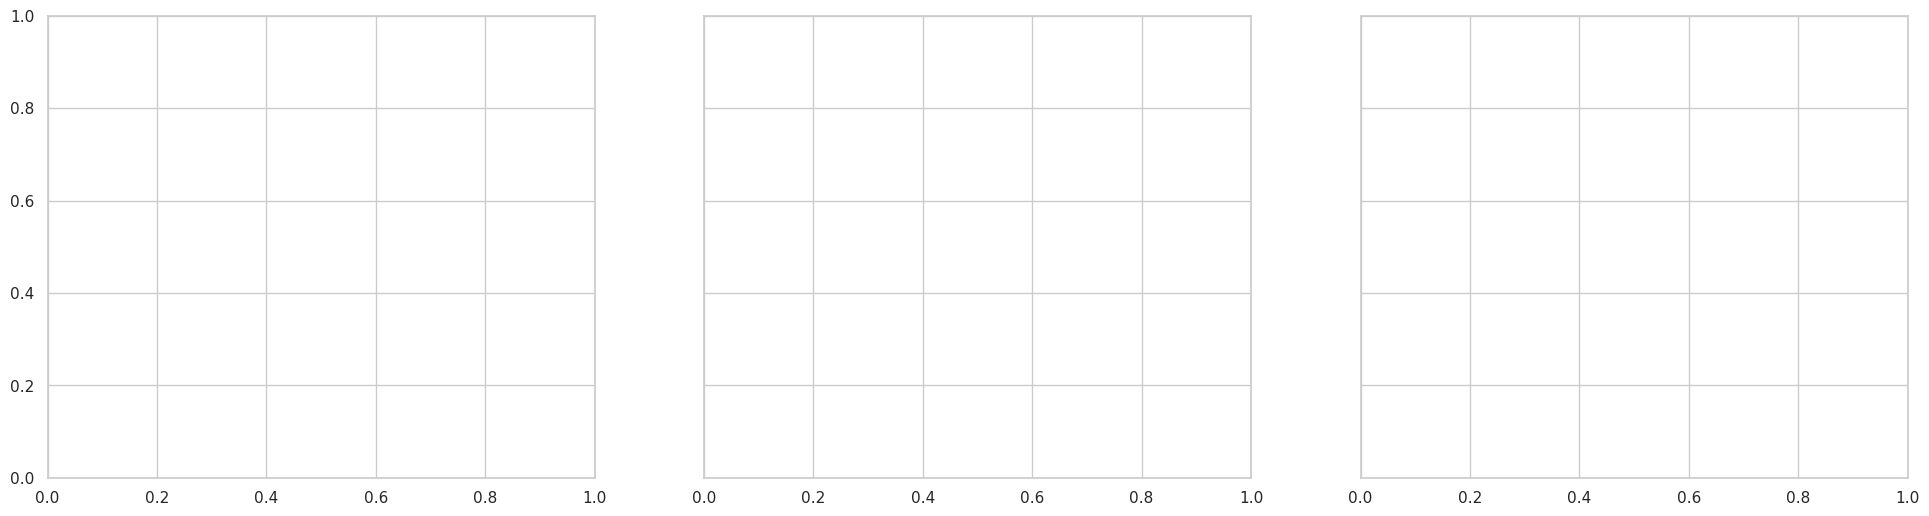

In [105]:


def plot_jaccard_results(results_df_global, results_df_inter, results_df_intra, pert_comparisons, plot=True, save=False, save_path=""):
    """
    Plot Jaccard similarity results together in a grid for different structure types.

    Parameters:
    - results_df_global (pd.DataFrame): DataFrame containing global structure Jaccard similarities.
    - results_df_inter (pd.DataFrame): DataFrame containing inter-class structure Jaccard similarities.
    - results_df_intra (pd.DataFrame): DataFrame containing intra-class structure Jaccard similarities.
    - pert_comparisons (list): List of perturbations to ensure consistent ordering.
    - plot (bool): Whether to display the plots interactively. Defaults to True.
    - save (bool): Whether to save the plots to files. Defaults to False.
    - save_path (str): Directory path where plots will be saved if `save=True`.

    Returns:
    - None
    """
    sns.set(style="whitegrid")

    # Define the order of the datasets for consistent coloring
    dataset_order = results_df_global['DataFrame'].unique()
    
    # Create a color palette
    palette = sns.color_palette('tab10', n_colors=len(dataset_order))
    color_dict = dict(zip(dataset_order, palette))

    # Metrics to plot
    plot_configs = [
        (results_df_global, 'Point-Similarity; Global Structure', 'Global'),
        (results_df_inter, 'Point-Similarity; Inter-Class Structure', 'Inter'),
        (results_df_intra, 'Point-Similarity; Intra-Class Structure', 'Intra')
    ]

    num_plots = len(plot_configs)
    fig, axes = plt.subplots(1, num_plots, figsize=(8*num_plots, 6), sharey=True)

    # Ensure axes is iterable
    if num_plots == 1:
        axes = [axes]

    for ax, (df, title, suffix) in zip(axes, plot_configs):
        # Ensure 'Perturbation' is categorical with the defined order
        df['Perturbation'] = pd.Categorical(df['Perturbation'], categories=pert_comparisons, ordered=True)
        df = df.sort_values('Perturbation')
        
        # Create the bar plot
        sns.barplot(
            data=df,
            x='Perturbation',
            y='Jaccard Similarity',
            hue='DataFrame',
            hue_order=dataset_order,
            ax=ax,
            ci=None,
            palette=color_dict
        )
        
        ax.set_title(title, fontsize=16)
        ax.set_xlabel('Perturbations', fontsize=14)
        ax.set_ylabel('Average Jaccard Similarity' if ax == axes[0] else '', fontsize=14)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.grid(axis='y', linestyle='--', alpha=0.7)
        
        # Annotate bars with similarity values
        for p in ax.patches:
            height = p.get_height()
            ax.annotate(f"{height:.2f}",
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom', fontsize=12)
        
        # Remove legend from all but the last subplot
        if ax != axes[-1]:
            ax.get_legend().remove()

    # Add a single legend for the entire figure
    handles, labels = axes[-1].get_legend_handles_labels()
    fig.legend(handles, labels, title='Dataset', loc='upper right')

    # Add a global title
    fig.suptitle('Jaccard Similarity Across Different Structures', fontsize=18)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to accommodate suptitle

    # Save the plot if save=True
    if save:
        if not save_path:
            save_path = "path_to_save_directory"  # Replace with your desired path
        filename = f"jaccard_similarity_results.png"
        full_save_path = os.path.join(save_path, filename)
        plt.savefig(full_save_path, bbox_inches='tight')
        print(f"Jaccard similarity plot saved to: {full_save_path}")

    # Display the plot if plot=True
    if plot:
        plt.show()

    # Close the plot to free memory
    plt.close()

In [111]:

# Compute the Jaccard similarities and get the separate results DataFrames
results_df_global, results_df_inter, results_df_intra = compute_jaccard_similarities(
    orig_df=df_all,
    dataframes=dataframes,
    comparisons=pert_comparisons,
    z_mu_biological_columns=z_mu_biological_columns,
    k_neighbors=k_neighbors,
    subsample_fraction=subsample_fraction
)


Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i


In [ ]:
# Extract the first two rows for testing
test_paired_models_df = paired_models_df.head(2)

# Define the list of parameter columns
parameter_cols = [
    'metric_loss_type',
    'margin',
    'metric_weight',
    'self_target_prob',
    'time_only_flag',
    'temperature',
    'learning_rate',
    'latent_dim',
    'beta',
    'batch_size',
    'zn_frac'
]

# Dictionaries to store test outputs
test_distance_metrics_dict = {}
test_metrics_inter_df_dict = {}
test_core_performance_metrics = {}
test_core_performance_metrics_summary_list = []

# Loop over the first two rows in test_paired_models_df
for i in range(len(test_paired_models_df)):
    row = test_paired_models_df.iloc[i]
    
    # Read the dataframes
    df_all = pd.read_csv(row["embryo_df_path_nohld"])
    df_hld = pd.read_csv(row["embryo_df_path_hld"])
    
    # Call the function
    core_performance_metrics, distance_metrics_intra_inter, metrics_inter_df = produce_performance_metrics(
        df_all,
        df_hld,
        pert_comparisons,
        logreg_tol=1e-3,
        subsample_fraction=0.05,
        subsample_fraction_jaccard=0.1,
        num_bins=20,
        max_hpf=40,
        random_state=100,
        plot=False,
        k_neighbors=5
    )
    
    # Compute summary statistics for core_performance_metrics
    summary_stats = core_performance_metrics.mean(numeric_only=True).to_dict()
    
    # Add the parameters to the summary_stats
    for param in parameter_cols:
        summary_stats[param] = row[param]
    
    # Add an identifier for the model
    summary_stats['model_index'] = i
    
    # Append to the test list
    test_core_performance_metrics_summary_list.append(summary_stats)
    
    # Store the other outputs in test dictionaries
    test_distance_metrics_dict[f"{i}_test"] = distance_metrics_intra_inter
    test_metrics_inter_df_dict[f"{i}_test"] = metrics_inter_df
    test_core_performance_metrics[f"{i}_test"] = core_performance_metrics

# Create a DataFrame from test_core_performance_metrics_summary_list
test_core_performance_metrics_summary_list_df = pd.DataFrame(test_core_performance_metrics_summary_list)

# Merge test_core_performance_metrics_summary_list_df back to test_paired_models_df on 'model_index'
test_paired_models_df = test_paired_models_df.reset_index().rename(columns={'index': 'model_index'})
test_paired_models_df = test_paired_models_df.merge(test_core_performance_metrics_summary_list_df, on='model_index', how='left')


/tmp/6509408.1.trapnell-login.q/ipykernel_1521002/641747166.py:30: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/6509408.1.trapnell-login.q/ipykernel_1521002/641747166.py:31: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/6509408.1.trapnell-login.q/ipykernel_1521002/3543003384.py:115: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/6509408.1.trapnell-login.q/ipykernel_1521002/3543003384.py:116: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i


/tmp/6509408.1.trapnell-login.q/ipykernel_1521002/641747166.py:30: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/6509408.1.trapnell-login.q/ipykernel_1521002/641747166.py:31: DtypeWarning:

Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.

/tmp/6509408.1.trapnell-login.q/ipykernel_1521002/3543003384.py:115: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/6509408.1.trapnell-login.q/ipykernel_1521002/3543003384.py:116: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/u

Processing DataFrame: No lmx1b gdf3
  Processing perturbation: wt
  Processing perturbation: lmx1b
  Processing perturbation: gdf3
  Processing perturbation: wnt-i
  Processing perturbation: tgfb-i
Test Paired Models DataFrame:
   model_index metric_loss_type_x  margin_x  metric_weight_x  \
0            0            NT-Xent       0.1               10   
1            1            NT-Xent       0.1               10   

   self_target_prob_x  time_only_flag_x  temperature_x  learning_rate_x  \
0                0.25                 0            0.1           0.0001   
1                0.25                 0            0.1           0.0001   

   latent_dim_x  beta_x  ...  margin_y  metric_weight_y self_target_prob_y  \
0           100     0.1  ...       0.1               10               0.25   
1           100    10.0  ...       0.1               10               0.25   

  time_only_flag_y temperature_y learning_rate_y  latent_dim_y  beta_y  \
0                0           0.1          0.

In [133]:

# Display the test results
test_paired_models_df



model_index metric_loss_type_x  margin_x  metric_weight_x  \
0            0            NT-Xent       0.1               10   
1            1            NT-Xent       0.1               10   

   self_target_prob_x  time_only_flag_x  temperature_x  learning_rate_x  \
0                0.25                 0            0.1           0.0001   
1                0.25                 0            0.1           0.0001   

   latent_dim_x  beta_x  ...  margin_y  metric_weight_y self_target_prob_y  \
0           100     0.1  ...       0.1               10               0.25   
1           100    10.0  ...       0.1               10               0.25   

  time_only_flag_y temperature_y learning_rate_y  latent_dim_y  beta_y  \
0                0           0.1          0.0001           100     0.1   
1                0           0.1          0.0001           100    10.0   

   batch_size_y  zn_frac_y  
0          2048        0.2  
1          2048        0.2  

[2 rows x 39 columns]

In [7]:
sweep_df

metric_loss_type  margin  metric_weight  self_target_prob  time_only_flag  \
0            NT-Xent     0.1             10              0.50               0   
1            NT-Xent     0.1             10              0.50               1   
2            NT-Xent     0.1             10              0.50               1   
3            NT-Xent     0.1             25              0.25               0   
4            NT-Xent     0.1             25              0.50               1   
..               ...     ...            ...               ...             ...   
460          triplet     5.0             10              0.75               0   
461          triplet     5.0             25              0.25               0   
462          triplet     5.0             25              0.25               0   
463          triplet     5.0             25              0.50               0   
464          triplet     5.0             25              0.50               1   

     temperature  learning_rate  latent_dim  beta  batch_size  zn_frac  \
0            0.1         0.0001         100   1.0        2048      0.2   
1            0.1         0.0001         100   0.1        2048      0.2   
2            0.1         0.0001         100  10.0        2048      0.2   
3            0.1         0.0001         100  10.0        2048      0.2   
4            0.1         0.0001         100   0.1        2048      0.2   
..           ...            ...         ...   ...         ...      ...   
460          0.1         0.0001         100   0.1        2048      0.2   
461          0.1         0.0001         100   0.1        2048      0.2   
462          0.1         0.0001         100  10.0        2048      0.2   
463          0.1         0.0001         100  10.0        2048      0.2   
464          0.1         0.0001         100   1.0        2048      0.2   

     holdout_flag                                         model_path  \
0               1  /net/trapnell/vol1/home/nlammers/projects/data...   
1               1  /net/trapnell/vol1/home/nlammers/projects/data...   
2               0  /net/trapnell/vol1/home/nlammers/projects/data...   
3               0  /net/trapnell/vol1/home/nlammers/projects/data...   
4               0  /net/trapnell/vol1/home/nlammers/projects/data...   
..            ...                                                ...   
460             0  /net/trapnell/vol1/home/nlammers/projects/data...   
461             1  /net/trapnell/vol1/home/nlammers/projects/data...   
462             1  /net/trapnell/vol1/home/nlammers/projects/data...   
463             1  /net/trapnell/vol1/home/nlammers/projects/data...   
464             0  /net/trapnell/vol1/home/nlammers/projects/data...   

     completed  process_id  
0            1          20  
1            1          12  
2            1          48  
3            1          45  
4            1          27  
..         ...         ...  
460          1         496  
461          1         495  
462          1         415  
463          1         436  
464          1         411  

[465 rows x 15 columns]

In [8]:

# boolean filter. NOTE THAT SOME COMBOS WILL NOT BE PRESENT (yet)
df_filter = (sweep_df["metric_loss_type"] == metric_loss_type) & (sweep_df["margin"] == margin) & (sweep_df["metric_weight"] == metric_weight) & \
            (sweep_df["self_target_prob"] == self_target_prob) & (sweep_df["time_only_flag"] == time_only_flag) & (sweep_df["holdout_flag"] == holdout_flag) & \
            (sweep_df["beta"] == beta)

sum(df_filter)

0

/tmp/6596508.1.trapnell-login.q/ipykernel_2982011/2376044569.py:28: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_all = pd.read_csv(find_embryo_stats_csv(model_path))
/tmp/6596508.1.trapnell-login.q/ipykernel_2982011/2376044569.py:48: DtypeWarning: Columns (2) have mixed types. Specify dtype option on import or set low_memory=False.
  df_hld = pd.read_csv(find_embryo_stats_csv(model_path))
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['class_num'] = train_df['class_num'].astype(int)
/net/trapnell/vol1/home/mdcolon/proj/morphseq/src/functions/embryo_df_performance_metrics.py:116: Sett

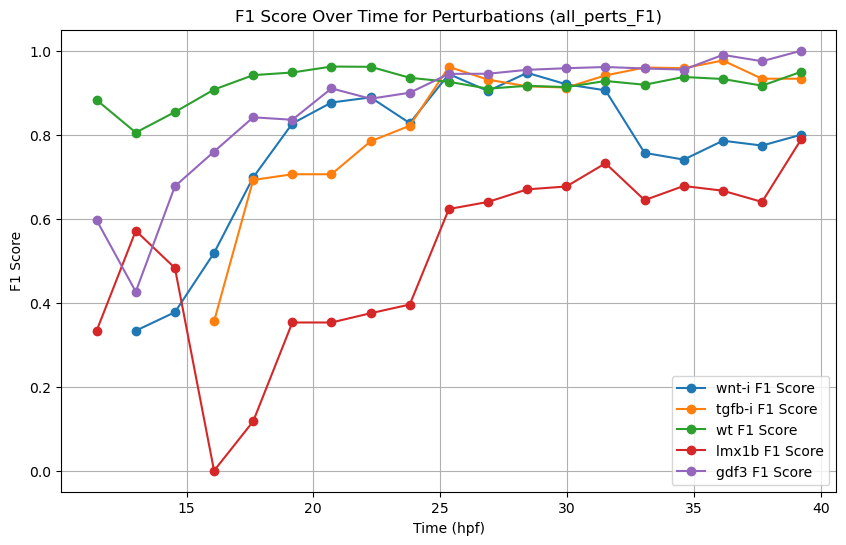

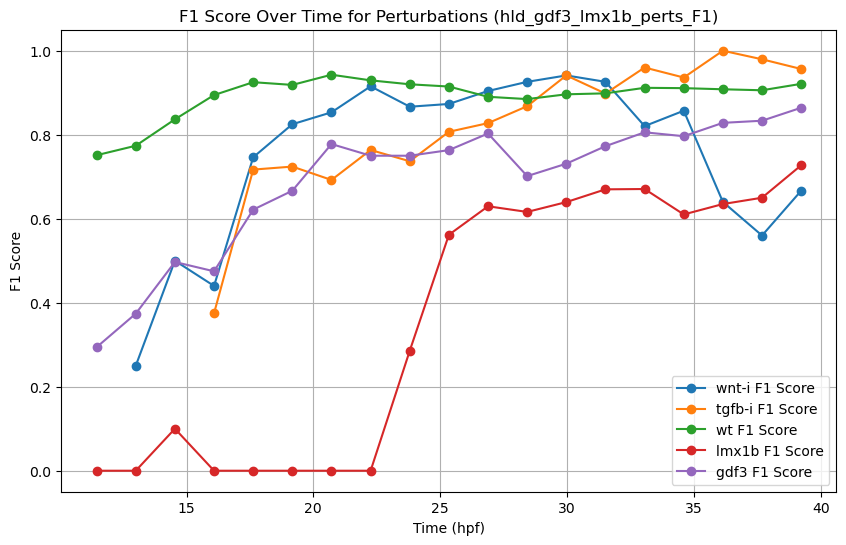

KeyError: 'perturbation'

In [ ]:
# an example
metric_loss_type = "NT-Xent"
margin = 5.0
metric_weight = 50
self_target_prob = 0.25
time_only_flag = 0
beta = .1


#~~~
holdout_flag = 0 

# boolean filter. NOTE THAT SOME COMBOS WILL NOT BE PRESENT (yet)
df_filter = (sweep_df["metric_loss_type"] == metric_loss_type) & (sweep_df["margin"] == margin) & (sweep_df["metric_weight"] == metric_weight) & \
            (sweep_df["self_target_prob"] == self_target_prob) & (sweep_df["time_only_flag"] == time_only_flag) & (sweep_df["holdout_flag"] == holdout_flag) & \
            (sweep_df["beta"] == beta)

# now, get training folder path
if np.any(df_filter):
    model_path = sweep_df.loc[df_filter, "model_path"].values[0]
    model_name = os.path.basename(model_path)
    # a couple of parameters for the model assessment script
    overwrite_flag = False # will skip if it detects the exprected output data already
    n_image_figures = 100  # make qualitative side-by-side reconstruction figures
    #had to change skip figures to true because i didnt have write access. 
    # assess_vae_results(root, train_fold
    
df_all = pd.read_csv(find_embryo_stats_csv(model_path))

#~~~
holdout_flag = 1 

# boolean filter. NOTE THAT SOME COMBOS WILL NOT BE PRESENT (yet)
df_filter = (sweep_df["metric_loss_type"] == metric_loss_type) & (sweep_df["margin"] == margin) & (sweep_df["metric_weight"] == metric_weight) & \
            (sweep_df["self_target_prob"] == self_target_prob) & (sweep_df["time_only_flag"] == time_only_flag) & (sweep_df["holdout_flag"] == holdout_flag) & \
            (sweep_df["beta"] == beta)

# now, get training folder path
if np.any(df_filter):
    model_path = sweep_df.loc[df_filter, "model_path"].values[0]
    model_name = os.path.basename(model_path)
    # a couple of parameters for the model assessment script
    overwrite_flag = False # will skip if it detects the exprected output data already
    n_image_figures = 100  # make qualitative side-by-side reconstruction figures
    #had to change skip figures to true because i didnt have write access. 
    # assess_vae_results(root, train_fold
    
df_hld = pd.read_csv(find_embryo_stats_csv(model_path))
#~~~



# Split the data
df_all_train, df_all_test, df_all = split_train_test(df_all)
df_hld_train, df_hld_test, df_hld = split_train_test(df_hld)

# Define the comparisons (Multiclass) and obtain coloumns for data
pert_comparisons = ["wnt-i", "tgfb-i", "wt", "lmx1b", "gdf3"]
z_mu_columns = [col for col in df_all.columns if 'z_mu' in col]    
z_mu_biological_columns = [col for col in z_mu_columns if "b" in col]

# --- Example usage with logistic_regression_multiclass (all suffix) ---
y_test_all, y_pred_proba_all, log_reg_all, train_df_all, test_df_all = logistic_regression_multiclass(
    df_all_train, df_all_test, z_mu_biological_columns, pert_comparisons)

# --- Example usage with logistic_regression_multiclass (hld suffix) ---
y_test_hld, y_pred_proba_hld, log_reg_hld, train_df_hld, test_df_hld = logistic_regression_multiclass(
    df_hld_train, df_hld_test, z_mu_biological_columns, pert_comparisons)


##all
results_dict_all = f1_score_over_time_multiclass(y_test_all, y_pred_proba_all, test_df_all, pert_comparisons, num_bins=20, max_hpf=40)
dataset_label = 'all_perts_F1'
plot_f1_score_over_time(results_dict_all, pert_comparisons, dataset_label=dataset_label, title="F1 Score Over Time for Perturbations")

#hld
results_dict_hld = f1_score_over_time_multiclass(y_test_hld, y_pred_proba_hld, test_df_hld, pert_comparisons, num_bins=20, max_hpf=40)
dataset_label = 'hld_gdf3_lmx1b_perts_F1'
plot_f1_score_over_time(results_dict_hld, pert_comparisons, dataset_label=dataset_label, title="F1 Score Over Time for Perturbations")


import pandas as pd
import numpy as np
import plotly.express as px
from sklearn.decomposition import PCA

def plot_pca_highlighted_embryos(
    test_df,
    z_mu_biological_columns,
    perturbations=None,
    highlight_embryos=None,
    highlight_colors=None,
    marker_size=5,
    highlight_marker_size=10,
    opacity=0.7,
    title="3D PCA Plot",
    show_legend=True,
    plot=True,
    downsample_wt=False,
    wt_downsample_frac=0.1,
    random_state=42
):
    # Copy the dataframe to avoid modifying the original data
    df = test_df.copy()

    # Downsample wild-type data if enabled
    if downsample_wt:
        # Identify wild-type entries (assuming 'perturbation' column indicates perturbation status)
        wt_mask = df['phenotype'] == 'wt'
        wt_df = df[wt_mask]
        perturbed_df = df[~wt_mask]

        # Get unique embryo_ids for wild-type
        unique_wt_embryos = wt_df['embryo_id'].unique()

        # Calculate the number of embryos to sample
        n_sample = max(1, int(len(unique_wt_embryos) * wt_downsample_frac))

        # Randomly sample embryo_ids
        sampled_embryos = np.random.RandomState(random_state).choice(
            unique_wt_embryos, size=n_sample, replace=False
        )

        # Filter the wild-type dataframe
        wt_df_sampled = wt_df[wt_df['embryo_id'].isin(sampled_embryos)]

        # Combine back with perturbed data
        df = pd.concat([wt_df_sampled, perturbed_df], ignore_index=True)
    
    # Prepare data for PCA
    X = df[z_mu_biological_columns].values

    # Perform PCA
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)
    df_pca = pd.DataFrame(pcs, columns=['PC1', 'PC2', 'PC3'])
    df_pca = pd.concat([df.reset_index(drop=True), df_pca], axis=1)

    # Prepare color and size settings
    if perturbations is None:
        perturbations = df_pca['phenotype'].unique()
    color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}
    
    # Handle embryo highlighting
    df_pca['marker_size'] = marker_size
    df_pca['opacity'] = opacity
    df_pca['color'] = df_pca['phenotype'].map(color_discrete_map)

    if highlight_embryos:
        if highlight_colors is None:
            highlight_colors = ['red'] * len(highlight_embryos)
        highlight_dict = dict(zip(highlight_embryos, highlight_colors))
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'marker_size'] = highlight_marker_size
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'color'] = df_pca['embryo_id'].map(highlight_dict)
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'opacity'] = 1.0

    if plot:
        fig = px.scatter_3d(
            df_pca,
            x='PC1',
            y='PC2',
            z='PC3',
            color='phenotype',
            symbol='phenotype`  ',
            size='marker_size',
            opacity=df_pca['opacity'],
            color_discrete_map=color_discrete_map,
            title=title
        )

        if not show_legend:
            fig.update_layout(showlegend=False)

        fig.show()

    return fig  # Return the PCA-transformed dataframe for further use


# Assuming you have a dataframe 'test_df' with the necessary columns
fig = plot_pca_highlighted_embryos(
    test_df=test_df_all,
    z_mu_biological_columns=z_mu_biological_columns,  # replace with your actual columns
    downsample_wt=True,
    wt_downsample_frac=0.05  # Adjust the fraction as needed
)


# Call the function
# fig = plot_pca_highlighted_embryos(
#     test_df=test_df_all,
#     z_mu_biological_columns=z_mu_biological_columns,
#     perturbations= pert_comparisons,
#     marker_size=3,
#     highlight_marker_size=5,
#     opacity=0.3,
#     title="Embryo PCA with Highlights",
#     show_legend=True,
#     plot=True
# )

# # Call the function
# fig = plot_pca_highlighted_embryos(
#     test_df=test_df_hld,
#     z_mu_biological_columns=z_mu_biological_columns,
#     perturbations= pert_comparisons,
#     marker_size=3,
#     highlight_marker_size=5,
#     opacity=0.3,
#     title="Embryo PCA with Highlights",
#     show_legend=True,
#     plot=True
# )

In [ ]:

def plot_pca_highlighted_embryos(
    test_df,
    z_mu_biological_columns,
    perturbations=None,
    highlight_embryos=None,
    highlight_colors=None,
    marker_size=5,
    highlight_marker_size=10,
    opacity=0.7,
    title="3D PCA Plot",
    show_legend=True,
    plot=True,
    downsample_wt=False,
    wt_downsample_frac=0.1,
    random_state=42
):
    # Copy the dataframe to avoid modifying the original data
    df = test_df.copy()

    # Downsample wild-type data if enabled
    if downsample_wt:
        # Identify wild-type entries (assuming 'perturbation' column indicates perturbation status)
        wt_mask = df['phenotype'] == 'wt'
        wt_df = df[wt_mask]
        perturbed_df = df[~wt_mask]

        # Get unique embryo_ids for wild-type
        unique_wt_embryos = wt_df['embryo_id'].unique()

        # Calculate the number of embryos to sample
        n_sample = max(1, int(len(unique_wt_embryos) * wt_downsample_frac))

        # Randomly sample embryo_ids
        sampled_embryos = np.random.RandomState(random_state).choice(
            unique_wt_embryos, size=n_sample, replace=False
        )

        # Filter the wild-type dataframe
        wt_df_sampled = wt_df[wt_df['embryo_id'].isin(sampled_embryos)]

        # Combine back with perturbed data
        df = pd.concat([wt_df_sampled, perturbed_df], ignore_index=True)
    
    # Prepare data for PCA
    X = df[z_mu_biological_columns].values

    # Perform PCA
    pca = PCA(n_components=3)
    pcs = pca.fit_transform(X)
    df_pca = pd.DataFrame(pcs, columns=['PC1', 'PC2', 'PC3'])
    df_pca = pd.concat([df.reset_index(drop=True), df_pca], axis=1)

    # Prepare color and size settings
    if perturbations is None:
        perturbations = df_pca['phenotype'].unique()
    color_discrete_map = {pert: px.colors.qualitative.Plotly[i % 10] for i, pert in enumerate(perturbations)}
    
    # Handle embryo highlighting
    df_pca['marker_size'] = marker_size
    df_pca['opacity'] = opacity
    df_pca['color'] = df_pca['phenotype'].map(color_discrete_map)

    if highlight_embryos:
        if highlight_colors is None:
            highlight_colors = ['red'] * len(highlight_embryos)
        highlight_dict = dict(zip(highlight_embryos, highlight_colors))
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'marker_size'] = highlight_marker_size
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'color'] = df_pca['embryo_id'].map(highlight_dict)
        df_pca.loc[df_pca['embryo_id'].isin(highlight_embryos), 'opacity'] = .8

    if plot:
        fig = px.scatter_3d(
            df_pca,
            x='PC1',
            y='PC2',
            z='PC3',
            color='phenotype',
            symbol='phenotype',
            size='marker_size',
            opacity="opacity",
            color_discrete_map=color_discrete_map,
            title=title
        )

        if not show_legend:
            fig.update_layout(showlegend=False)

        fig.show()

    return fig  # Return the PCA-transformed dataframe for further use


# Assuming you have a dataframe 'test_df' with the necessary columns
fig = plot_pca_highlighted_embryos(
    test_df=test_df_all,
    z_mu_biological_columns=z_mu_biological_columns,  # replace with your actual columns
    downsample_wt=True,
    wt_downsample_frac=0.05  # Adjust the fraction as needed
)


ValueError: 
    Invalid value of type 'numpy.ndarray' received for the 'opacity' property of scatter3d.marker
        Received value: array([0.7])

    The 'opacity' property is a number and may be specified as:
      - An int or float in the interval [0, 1]